## Calculation of lightning geolocation based on data grabbed from VLF antenna

The Parallella (Pcko) grabbing unit was used to capture triggered data from ortogal loop antennas.

In [1]:
import os
import sys
from readrec import *
import matplotlib
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
import re

from scipy.constants import speed_of_light

c = speed_of_light

sps = 10e6 # 10 Msps

%matplotlib inline
%config InlineBackend.close_figures=True

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from readrec import loadrec, assign_time_axis  # Assuming readrec.py contains these functions

def multistation_plotrec(files):
    channels = [0, 1, 3]
    nrows = len(channels) * len(files)
    fig, axs = plt.subplots(figsize=(35, 7 * nrows), nrows=nrows, sharex=True)
    
    mintime = None
    data = []
    
    # Load and process data
    for filepath in files:
        try:
            with open(filepath, 'rb') as file:
                fn = os.path.basename(filepath)
                h, samples, synclog = loadrec(file)
                t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)
                
                time = s2t(0)
                mintime = time if mintime is None else min(mintime, time)

                # Add data to the list for later processing
                data.append((filepath, h, samples, synclog, t2s, s2t, ticker, formatter))
        except Exception as e:
            print(f"Exception: {e}")

    # Render data
    ax_idx = 0
    for i, (filepath, h, samples, synclog, t2s, s2t, ticker, formatter) in enumerate(data):
        offset = -int(t2s(mintime))
        
        # Use full path for the file label only once above the first channel
        axs[ax_idx].set_title(f"File: {filepath}", fontsize=40, pad=20)

        for ch in channels:
            a = (h['preTrigger'] - h['preTrigger']) * h['descSpan'] // 16
            b = (h['preTrigger'] + h['postTrigger']) * h['descSpan'] // 16
            signal_samples = samples[a:b, ch]
            
            axs[ax_idx].xaxis.set_major_locator(ticker)
            axs[ax_idx].xaxis.set_major_formatter(formatter)
            axs[ax_idx].plot(range(a + offset, b + offset), signal_samples, linestyle="", marker=".", alpha=0.5, markersize=1)
            
            # Improved channel label visibility
            axs[ax_idx].annotate(f"Channel: {ch}", xy=(0.01, 0.85), xycoords='axes fraction', fontsize=30, backgroundcolor='white')
            
            axs[ax_idx].tick_params(axis='x', which='major', labelsize=35)
            axs[ax_idx].tick_params(axis='y', which='major', labelsize=35)
            
            ax_idx += 1

    plt.tight_layout()
    plt.show()


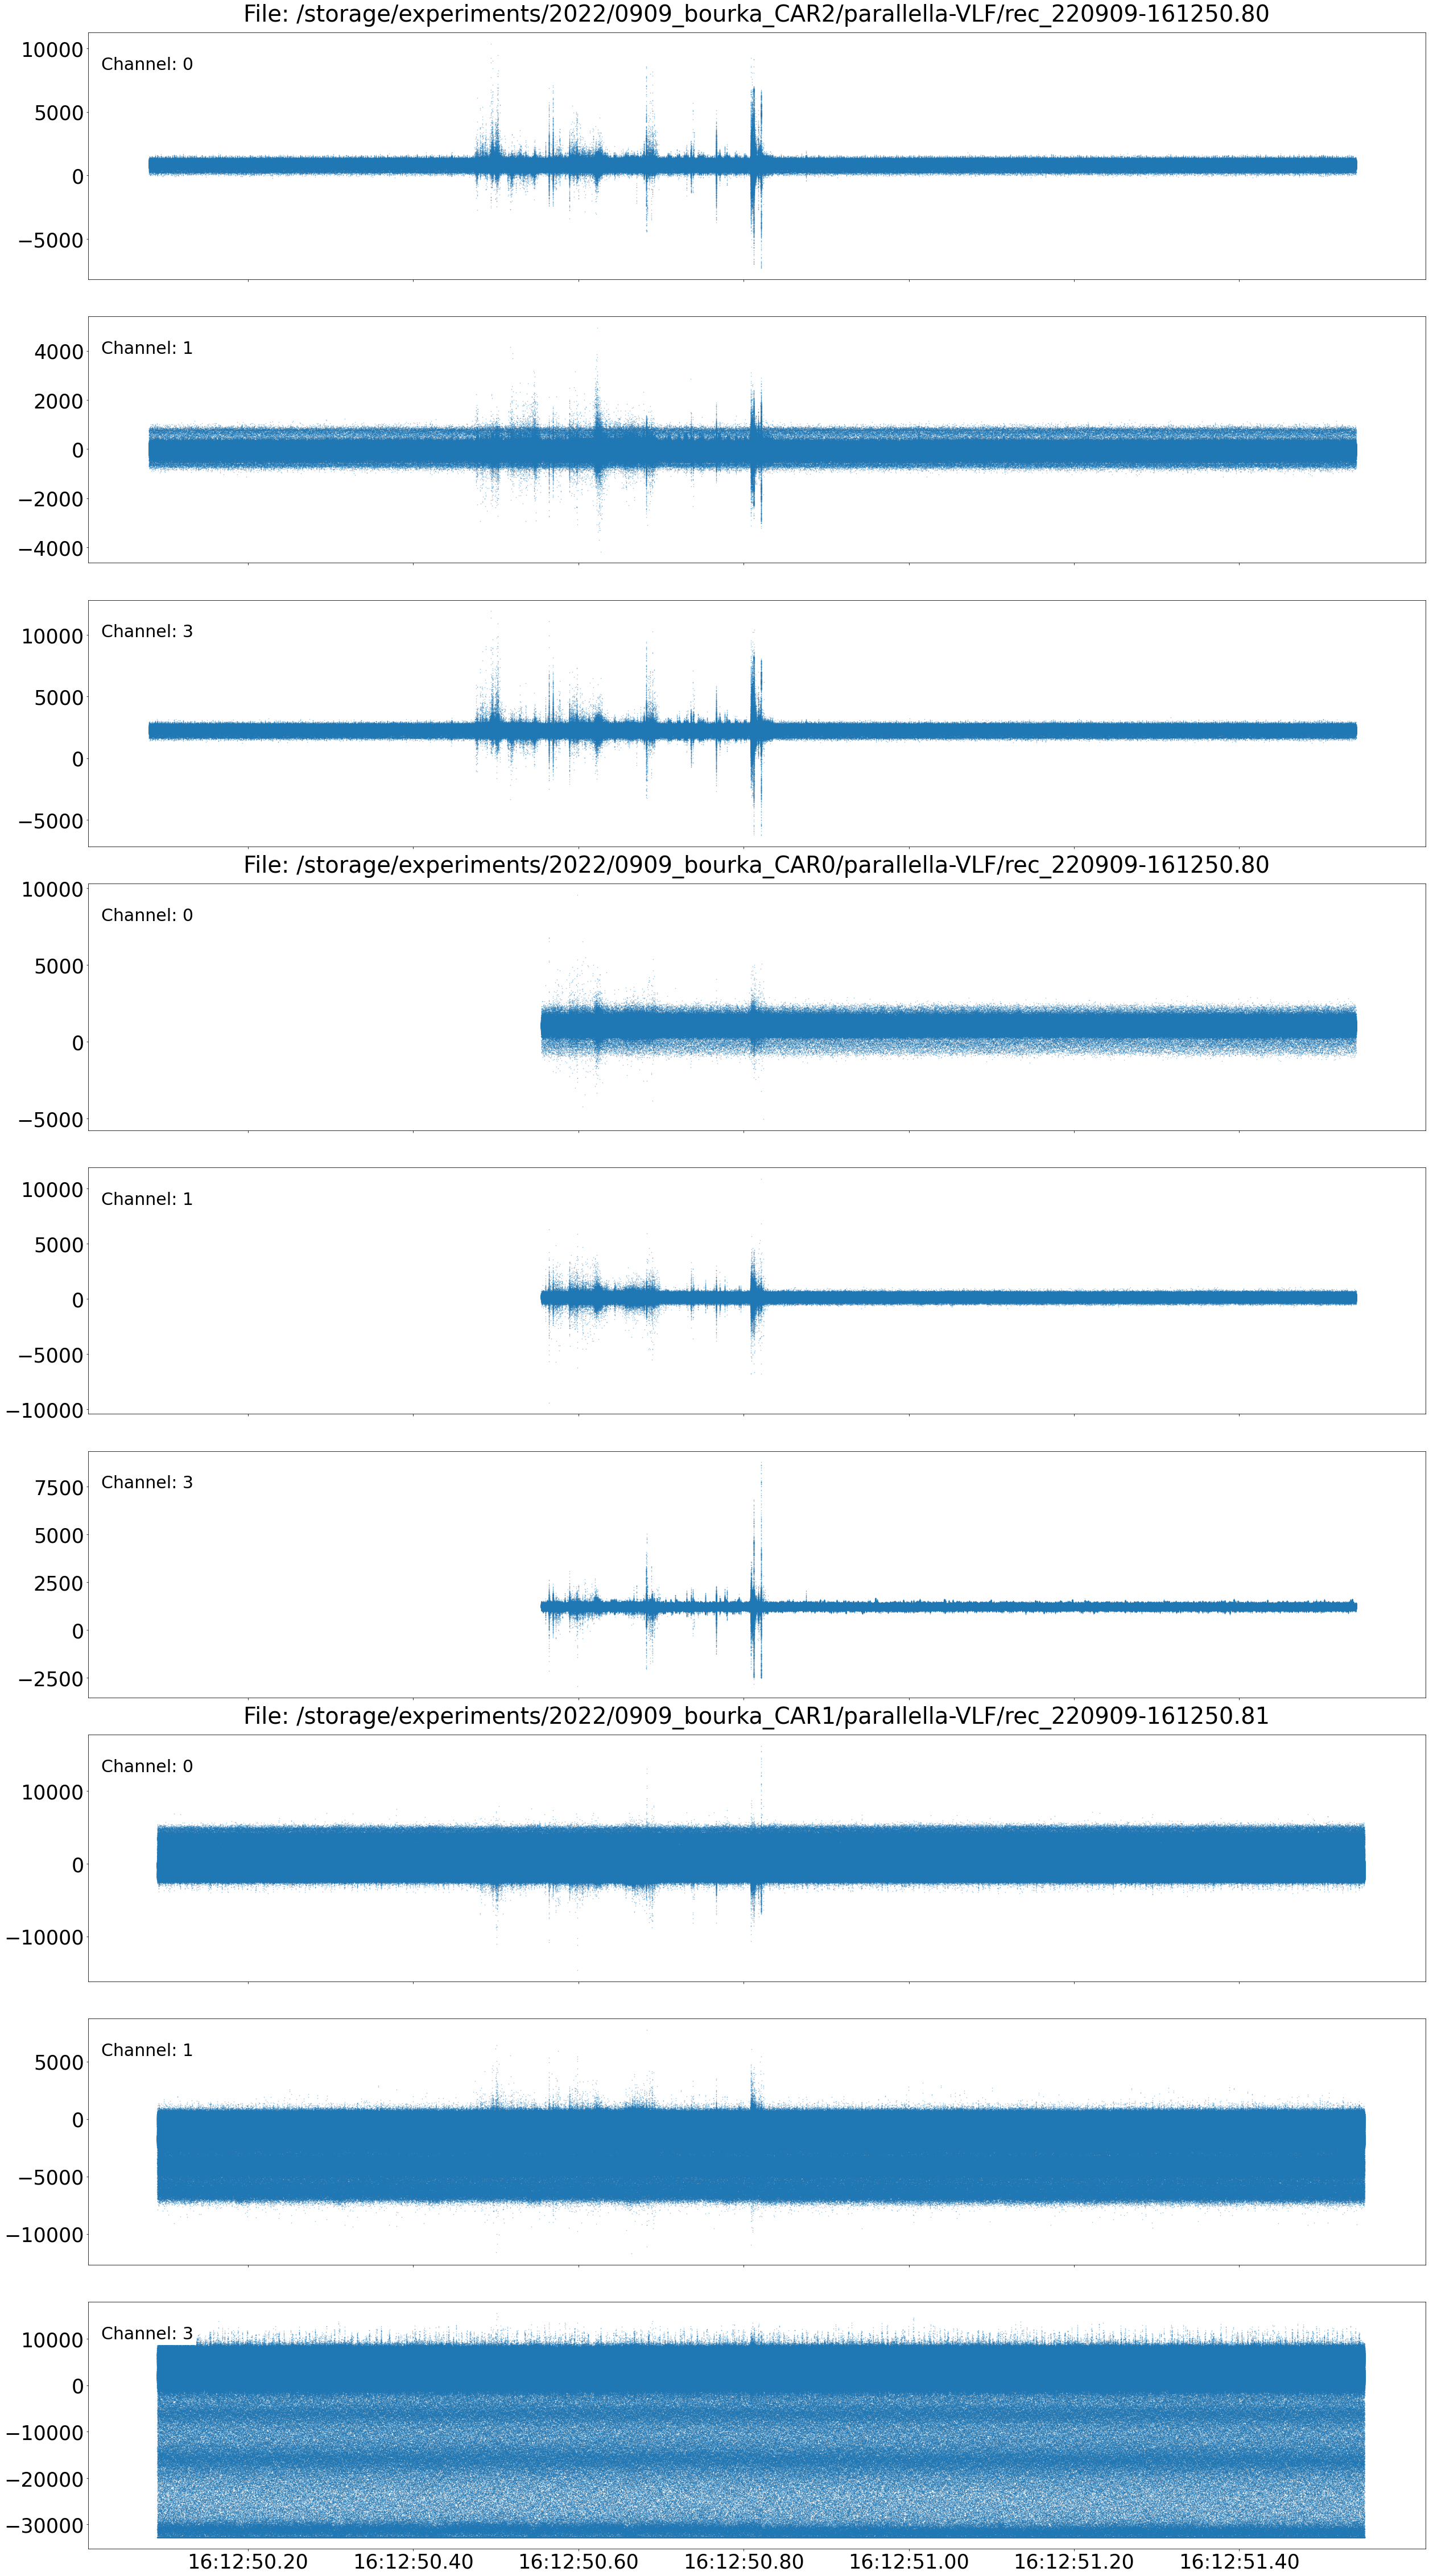

In [3]:
files = ['/storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-161250.80',
         '/storage/experiments/2022/0909_bourka_CAR0/parallella-VLF/rec_220909-161250.80',
         '/storage/experiments/2022/0909_bourka_CAR1/parallella-VLF/rec_220909-161250.81']

multistation_plotrec(files)

# Extraction of relevant signal fragments

That step extract a part of signals related to the lightning

In [4]:
def extract_signal_fragment(files, date_str, start_time_str, end_time_str, selected_channels):
    fragments = []
    
    # Převod celého časového řetězce na objekty Timestamp
    start_datetime = pd.to_datetime(f'{date_str} {start_time_str}')
    end_datetime = pd.to_datetime(f'{date_str} {end_time_str}')

    for filepath in files:
        try:
            car_match = re.search(r'CAR(\d+)', filepath)
            if car_match:
                station_id = car_match.group(1)
            else:
                raise ValueError("Identifikátor stanice nebyl nalezen v cestě k souboru.")
            with open(filepath, 'rb') as file:
                fn = os.path.basename(filepath)
                h, samples, synclog = loadrec(file)
                t2s, s2t, _, _ = assign_time_axis(fn, h, synclog)

                # Získání indexů vzorků pro začátek a konec
                start_index = int(t2s(start_datetime))
                actual_start_index = max(start_index, 0)  # Korekce start_index, pokud je mimo rozsah
                end_index = min(int(t2s(end_datetime)), samples.shape[0])
                
                num_samples = end_index - start_index  # Počet vzorků v požadovaném okně
                
                if num_samples <= 0:
                    print(f"Časové okno '{start_datetime}' až '{end_datetime}' je mimo rozsah záznamu v souboru {filepath}.")
                    continue

                # Příprava fragmentu
                if start_index < 0:
                    padding_length = abs(start_index)
                    # Výpočet střední hodnoty pro padding se provádí jen pro skutečně načtená data
                    fragment = samples[0:end_index, :][:, selected_channels]
                else:
                    fragment = samples[actual_start_index:end_index, :][:, selected_channels]
                
                fragment_mean = np.mean(fragment, axis=0).astype(np.int16)
                
                # Doplňování středními hodnotami namísto nul
                if start_index < 0:
                    padding = np.full((padding_length, fragment.shape[1]), fragment_mean, dtype=np.int16)
                    fragment = np.vstack((padding, fragment))
                if fragment.shape[0] < num_samples:
                    padding_length = num_samples - fragment.shape[0]
                    padding = np.full((padding_length, fragment.shape[1]), fragment_mean, dtype=np.int16)
                    fragment = np.vstack((fragment, padding))
                
                fragments.append(('CAR'+station_id+'_'+fn, fragment))
                
        except Exception as e:
            print(f"Chyba při zpracování souboru {filepath}: {e}")
    
    return fragments


In [5]:
## Manually select a part of signal which corresponds to the lightning

date_str = "2022-09-09"
time_window_start = "16:12:50.545"  # Začátek extrakce
time_window_end = "16:12:50.82"    # Konec extrakce
selected_channels = [0, 1, 3] # [3]
output_directory = "./test_data/"


fragments = extract_signal_fragment(files, date_str, time_window_start, time_window_end, selected_channels)

#for fn, fragment in fragments:
#    # Uložení fragmentu do binárního souboru
#    output_filename = f"{fn}_fragment.npy"
#    output_path = os.path.join(output_directory, output_filename)
#    np.save(output_path, fragment)
#    print(f"Fragment uložen do {output_path}")
#    print(f"Soubor: {fn}, Velikost fragmentu: {fragment.shape}, {fragment.dtype}")

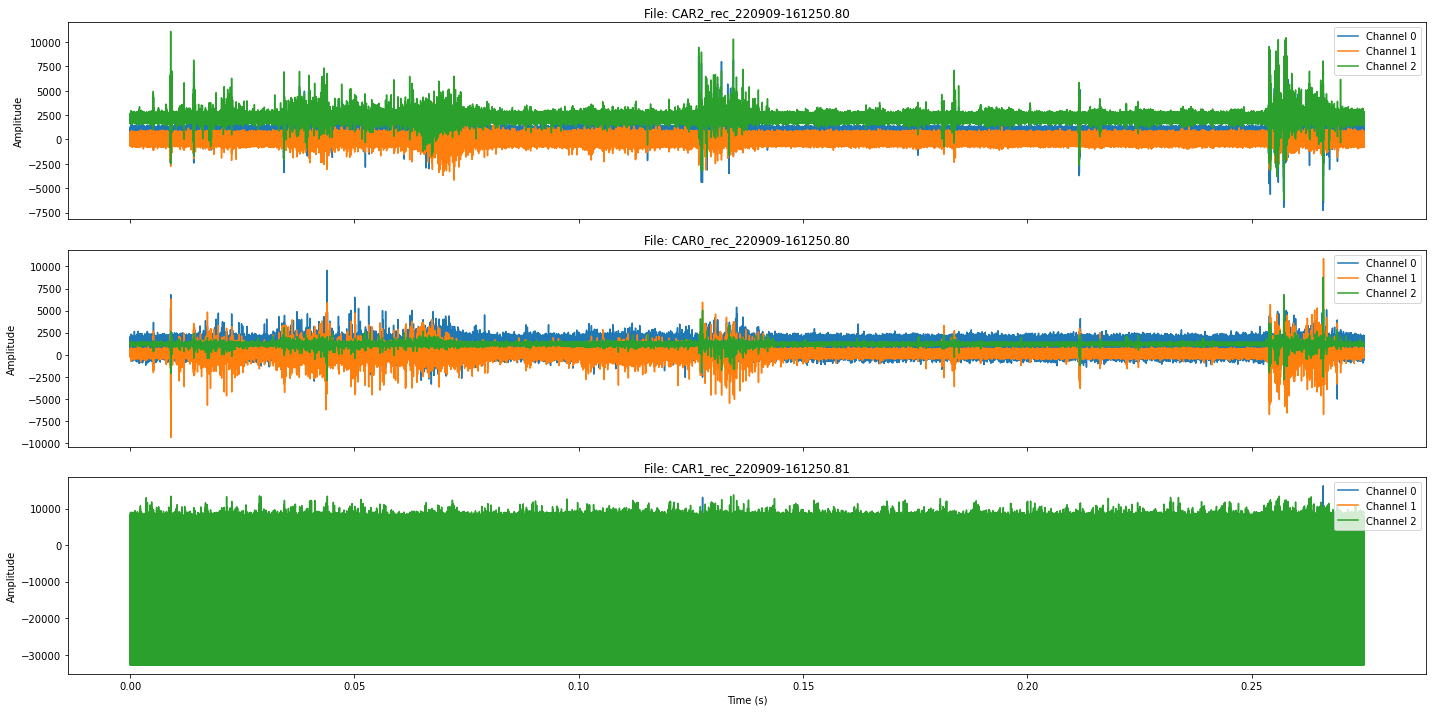

In [6]:
def plot_fragments(fragments, sps):
    num_fragments = len(fragments)
    fig, axs = plt.subplots(num_fragments, 1, figsize=(20, 10), sharex=True)

    if num_fragments == 1:  # If there's only one fragment, make axs an array
        axs = [axs]

    for i, (filename, fragment) in enumerate(fragments):
        # Ensure fragment is 2D for uniform processing
        if fragment.ndim == 1:
            fragment = fragment.reshape(-1, 1)  # Reshape 1D array to 2D array with one column
        
        # Create time axis (relative, starting at 0)
        time_axis = np.linspace(0, fragment.shape[0]/sps, num=fragment.shape[0])

        # Plot each channel in the fragment
        for ch in range(fragment.shape[1]):
            axs[i].plot(time_axis, fragment[:, ch], label=f'Channel {ch}')
        
        axs[i].set_title(f'File: {filename}')
        axs[i].set_ylabel('Amplitude')
        axs[i].legend(loc='upper right')

    axs[-1].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

# Example usage, assuming `normalized_fragments_combined` contains your combined signals
# and `sps` is defined as your sampling rate

plot_fragments(fragments,sps)


Normalizace signálů a jemné odstranění offsetu s rozlišením float32

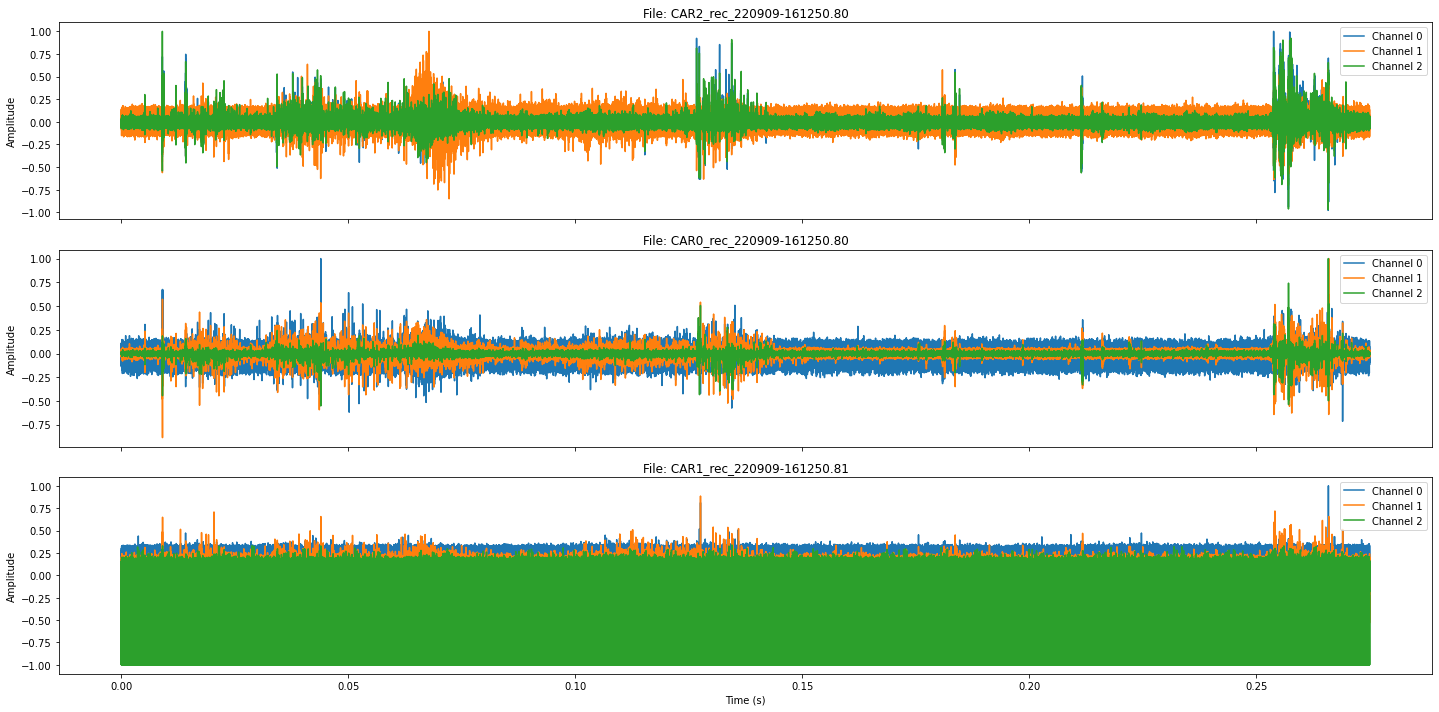

In [7]:
normalized_fragments = []

for fn, fragment in fragments:
    # Převedení na float pro zpracování
    fragment = fragment.astype(np.float32)
    
    # Odstranění DC offsetu pro každý kanál zvlášť
    fragment_mean = np.mean(fragment, axis=0)
    fragment -= fragment_mean[None, :]  # Použití broadcasting pro odčítání
    
    # Normalizace na rozsah -1 až 1 pro každý kanál zvlášť
    max_val = np.max(np.abs(fragment), axis=0)
    # Zabránění dělení nulou, nastavení nezměněných kanálů na nulu
    max_val[max_val == 0] = 1
    fragment /= max_val[None, :]  # Použití broadcasting pro dělení
    
    normalized_fragments.append((fn, fragment))


plot_fragments(normalized_fragments, sps)

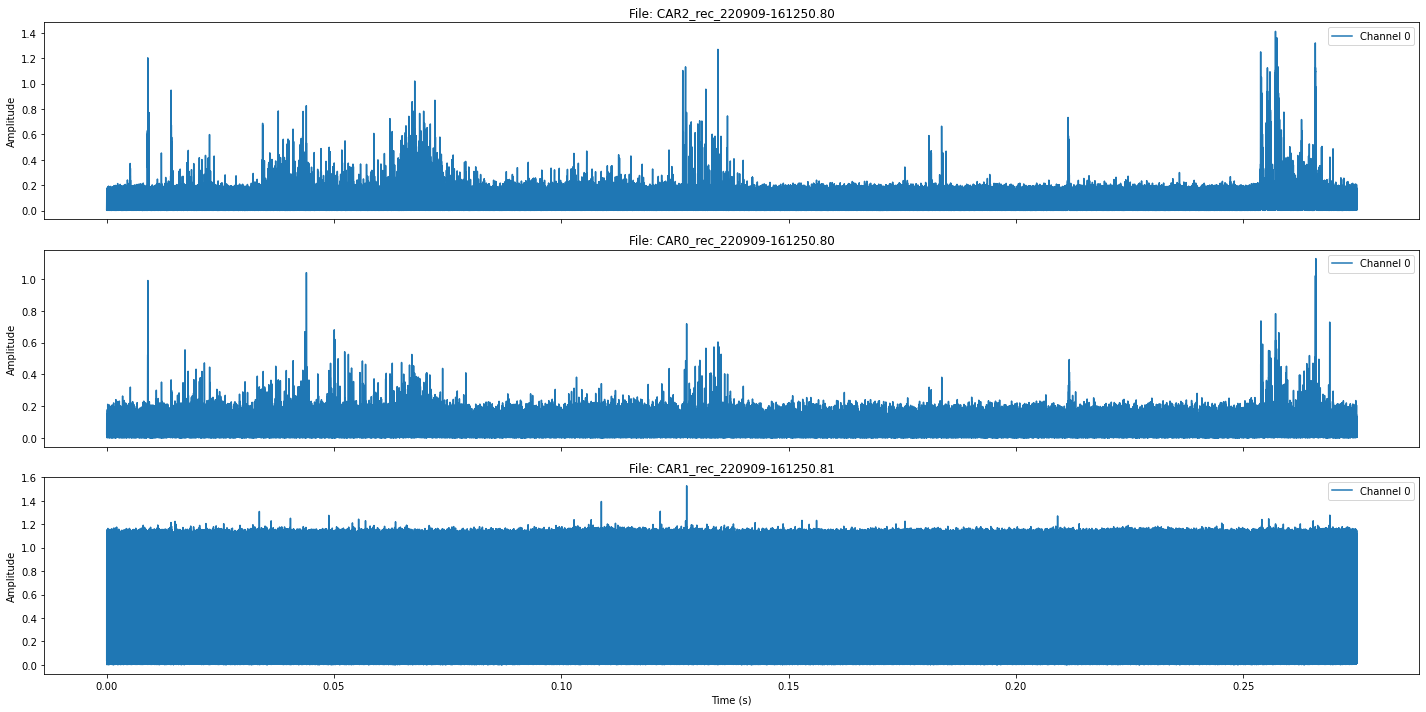

In [8]:
# Function to combine signals from three antennas into a single signal for each station
# and keep the station identifier
def combine_station_signals(normalized_fragments):
    combined_signals_with_ids = []
    
    for station_id, signal_fragment in normalized_fragments:
        # Compute the vector sum of the three signals at each station to combine them
        combined_signal = np.sqrt(np.sum(signal_fragment**2, axis=1))
        combined_signals_with_ids.append((station_id, combined_signal))
    
    return combined_signals_with_ids

# Call the function with the actual normalized_fragments data
normalized_fragments_combined = combine_station_signals(normalized_fragments)

plot_fragments(normalized_fragments_combined, sps)

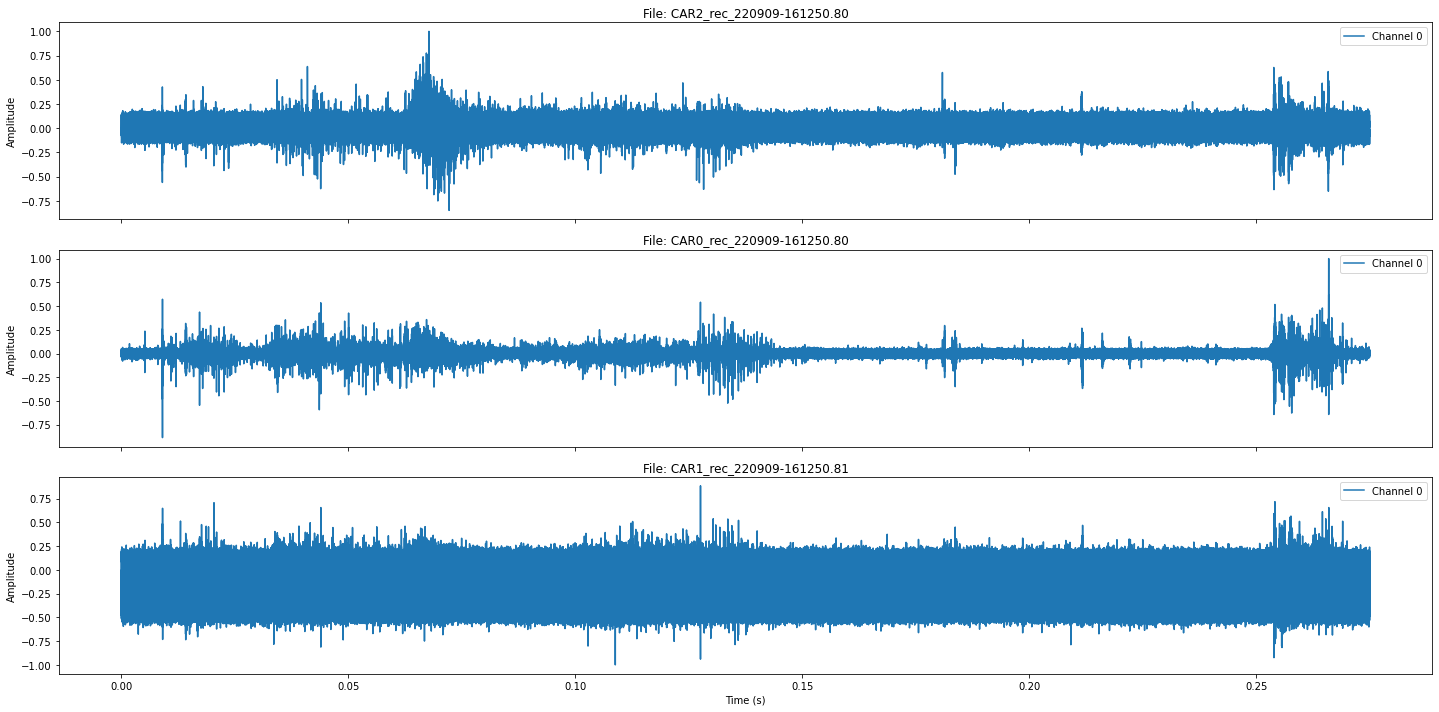

In [9]:
# Function to manually select signals from three antennas into a single signal for each station
# and keep the station identifier

signal_selection = [1,1,1]  # selec single channel from the each station 

def select_station_signals(normalized_fragments, signal_selection):
    selected_signals_with_ids = []
    # Iterate through each tuple in normalized_fragments
    for i, (identifier, signals) in enumerate(normalized_fragments):
        # Select the signal for each tuple based on signal_selection
        # Adjust for 0-based indexing by subtracting 1 from the selection index
        selected_signal = signals[:, signal_selection[i]]
        # Store the selected signal with its identifier
        selected_signals_with_ids.append((identifier, selected_signal))
    # Return the list of selected signals with identifiers
    return selected_signals_with_ids


# Call the function with the actual normalized_fragments data
normalized_fragments_selected = select_station_signals(normalized_fragments, signal_selection)

plot_fragments(normalized_fragments_selected, sps)

In [10]:
normalized_fragments_selected

[('CAR2_rec_220909-161250.80',
  array([-0.00286877, -0.02558748, -0.02558748, ...,  0.03283206,
         -0.01909642, -0.01585089], dtype=float32)),
 ('CAR0_rec_220909-161250.80',
  array([ 0.00785686,  0.01231927,  0.00934433, ..., -0.00701785,
         -0.01594268, -0.0099928 ], dtype=float32)),
 ('CAR1_rec_220909-161250.81',
  array([-0.00534177, -0.03627981, -0.04865503, ..., -0.06103025,
         -0.01771699, -0.0254515 ], dtype=float32))]

# Umístění měřících stanic

Zde jsou připraveny souřadnice a převedeny z formátu WGS84 do ECEF

In [11]:
import folium

# Define station positions
stations_geodetic = {
"CAR0": {"lat":50.469094667,"lon":13.765497667,"alt":372.600},
"CAR1": {"lat":50.523364667,"lon":13.543213167,"alt":244.200},
"CAR2": {"lat":50.393234833,"lon":13.693044500,"alt":210.300}
}

# Calculate the average latitude and longitude to center the map
avg_lat = sum(station["lat"] for station in stations_geodetic.values()) / len(stations_geodetic)
avg_lon = sum(station["lon"] for station in stations_geodetic.values()) / len(stations_geodetic)

# Create a map centered around the average location
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=10)

# Add markers for each station
for name, pos in stations_geodetic.items():
    folium.Marker([pos["lat"], pos["lon"]], popup=name).add_to(m)

# Display the map in Jupyter Notebook
m


In [12]:
from pyproj import Proj, Transformer

# Initialize WGS84 (lat/lon) and ECEF coordinate systems
wgs84 = Proj(proj='latlong', datum='WGS84')
ecef = Proj(proj='geocent', datum='WGS84')

# Initialize a transformer to convert from WGS84 to ECEF
transformer = Transformer.from_proj(wgs84, ecef)

# Function to convert from geodetic to ECEF coordinates
def geodetic_to_ecef(lat, lon, alt):
    x, y, z = transformer.transform(lon, lat, alt, radians=False)
    return (x, y, z)

# Dictionary to store ECEF coordinates
stations_ecef = {}

# Convert station positions to ECEF and store in dictionary
for station, position in stations_geodetic.items():
    stations_ecef[station] = geodetic_to_ecef(position['lat'], position['lon'], position['alt'])

# Print ECEF coordinates
for station, ecef_coords in stations_ecef.items():
    print(f"{station} ECEF:", ecef_coords)


CAR0 ECEF: (3951150.9657826284, 967973.2862059791, 4896452.478554733)
CAR1 ECEF: (3950268.4794502985, 951527.1885485708, 4900193.852594219)
CAR2 ECEF: (3958591.6731348936, 964491.5289012508, 4890951.79087182)


In [65]:
from itertools import combinations
import numpy as np

# Mapování identifikátorů na stanice
id_to_station = {
    'CAR0_rec_220909-161250.80': 'CAR0',
    'CAR1_rec_220909-161250.81': 'CAR1',
    'CAR2_rec_220909-161250.80': 'CAR2'
}


# Výpočet vzdáleností mezi stanicemi
distances = {}

for (name1, pos1), (name2, pos2) in combinations(stations_ecef.items(), 2):
    # Výpočet vzdálenosti mezi stanicemi
    distance = np.sqrt((pos2[0] - pos1[0])**2 + (pos2[1] - pos1[1])**2 + (pos2[2] - pos1[2])**2)
    # Uložení výsledku
    distances[(name1, name2)] = distance

distances



{('CAR0', 'CAR1'): 16889.3691411816,
 ('CAR0', 'CAR2'): 9886.572956086962,
 ('CAR1', 'CAR2'): 17965.672232678593}

# Korelace signálů mezi stanicemi

V tomto kroku jsou vypočteny TDOA z extrahovaných fragmentů signálů

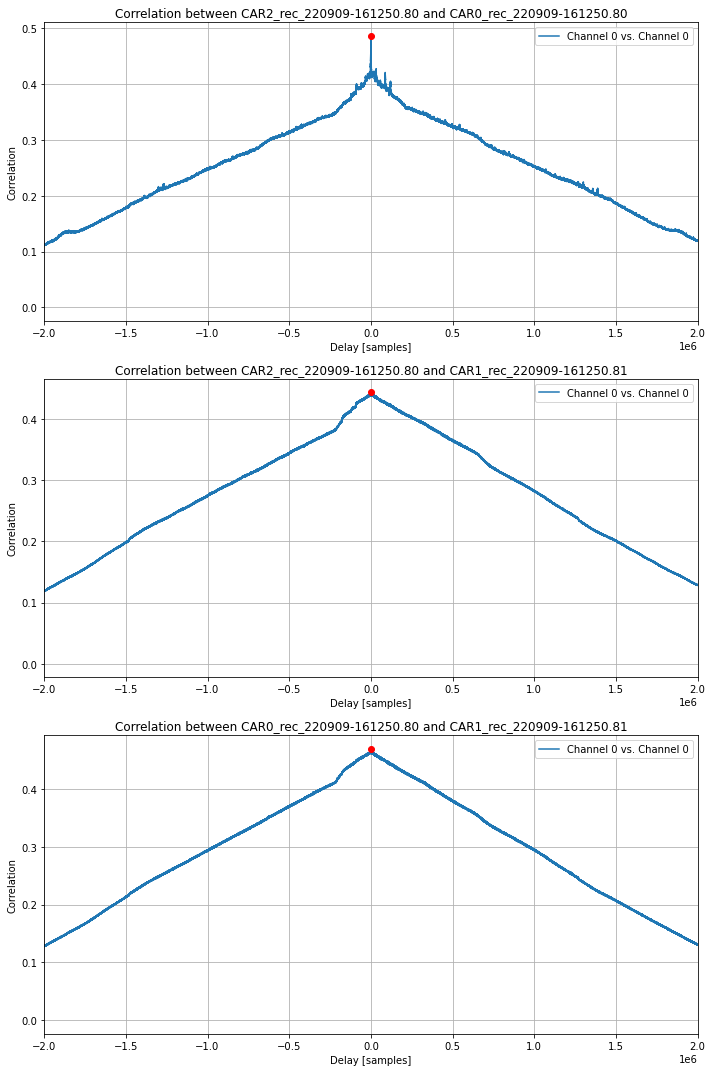

Delay between CAR2_rec_220909-161250.80 and CAR0_rec_220909-161250.80:
                Channel  1
            [µs]      [m] 
Channel  1    -31.5    -9443  


Delay between CAR2_rec_220909-161250.80 and CAR1_rec_220909-161250.81:
                Channel  1
            [µs]      [m] 
Channel  1    -43.6   -13071  


Delay between CAR0_rec_220909-161250.80 and CAR1_rec_220909-161250.81:
                Channel  1
            [µs]      [m] 
Channel  1    -17.8    -5336  




In [14]:
from itertools import combinations, product
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt

# Assuming `normalized_fragments_combined` and `id_to_station` are defined
# Assuming `sps` (samples per second) and `c` (speed of light) are defined
# Assuming `distances` dictionary contains physical distances between stations

# Convert absolute value of each signal sample to improve correlation quality
#data = {name: np.abs(fragment) for name, fragment in normalized_fragments_combined}
data = {name: np.abs(fragment) for name, fragment in normalized_fragments_selected}

# Setup figure for plotting
fig, axs = plt.subplots(nrows=len(data)*(len(data)-1)//2, ncols=1, figsize=(10, 15))
if len(data)*(len(data)-1)//2 == 1:
    axs = [axs]  # Make iterable even if there's only one plot

axs_idx = 0

# Store TDOA results for display
tdoa_results = {}

max_time_delays = {k: v / c for k, v in distances.items()}

for (name1, fragment1), (name2, fragment2) in combinations(data.items(), 2):
    # Convert record IDs to station names
    station1 = id_to_station[name1]
    station2 = id_to_station[name2]

    # Ensure keys are in alphabetical order for consistency
    station_pair = tuple(sorted([station1, station2]))

    # Maximum allowed delay between these stations in time units (seconds)
    max_delay_time = max_time_delays[station_pair]
    # Convert to samples
    max_delay_samples = int(max_delay_time * sps)

    # Check if the fragment is 1D (combined signal) or 2D (multiple channels), and adjust accordingly
    if fragment1.ndim == 1:
        fragment1 = fragment1.reshape(-1, 1)  # Convert to 2D with a single column
    if fragment2.ndim == 1:
        fragment2 = fragment2.reshape(-1, 1)  # Convert to 2D with a single column

    delay_matrix = np.zeros((fragment1.shape[1], fragment2.shape[1]))
    
    for channel1, channel2 in product(range(fragment1.shape[1]), range(fragment2.shape[1])):
        signal1, signal2 = fragment1[:, channel1], fragment2[:, channel2]
        corr = correlate(signal1, signal2, mode='full', method='auto')
        corr /= np.sqrt(np.dot(signal1, signal1) * np.dot(signal2, signal2))
        lags = np.arange(-len(signal1)+1, len(signal2))

        # Finding the index and value of maximum correlation
        max_corr_index = np.argmax(corr)
        max_corr_value = corr[max_corr_index]
        max_lag = lags[max_corr_index]

        # Check if maximum lag exceeds physical limits
        if abs(max_lag) > max_delay_samples:
            print(f"TDOA between {name1} and {name2} exceeds physical distance, searching for alternative...")
            # Example of searching for the next highest peak that meets the condition
            valid_corr_indices = np.where(abs(lags) <= max_delay_samples)[0]
            max_corr_index = valid_corr_indices[np.argmax(corr[valid_corr_indices])]
            max_lag = lags[max_corr_index]

        delay_matrix[channel1, channel2] = max_lag / sps

        # Plot correlation for this combination
        axs[axs_idx].plot(lags, corr, label=f'Channel {channel1} vs. Channel {channel2}')
        axs[axs_idx].plot(max_lag, corr[max_corr_index], 'ro')  # Highlight the new maximum

    axs[axs_idx].set_title(f'Correlation between {name1} and {name2}')
    axs[axs_idx].set_xlabel('Delay [samples]')
    axs[axs_idx].set_xlim(-2e6, 2e6)  # Adjust for better visualization if needed
    axs[axs_idx].set_ylabel('Correlation')
    axs[axs_idx].legend(loc="upper right")
    axs[axs_idx].grid(True)

    axs_idx += 1
    tdoa_results[(name1, name2)] = delay_matrix

plt.tight_layout()
plt.show()

for (station_pair, delay_matrix) in tdoa_results.items():
    print(f"Delay between {station_pair[0]} and {station_pair[1]}:")
    header_channels = "               " + "          ".join([f" Channel {i+1:2}" for i in range(delay_matrix.shape[1])])
    header_units = "        " + "    [µs]      [m] " * delay_matrix.shape[1]
    print(header_channels)
    print(header_units)

    # Print delay values in microseconds and meters with better formatting
    for i, row in enumerate(delay_matrix):
        row_str = f"Channel {i+1:2} " + "".join([f"{delay*1e6:8.1f} {delay*c:8.0f}  " for delay in row])
        print(row_str)
    print("\n")  # Separate tables for better readability


## Calculate single position from the whole lightning signal

In [122]:
import numpy as np
from scipy.optimize import minimize
from numpy.linalg import norm

# ECEF souřadnice stanic (příklad)
CAR0_ecef = stations_ecef['CAR0']
CAR1_ecef = stations_ecef['CAR1']
CAR2_ecef = stations_ecef['CAR2']

# TDOA hodnoty (s)
TDOA_CAR2_CAR0 = tdoa_results['CAR2_rec_220909-161250.80','CAR0_rec_220909-161250.80'][0][0]
TDOA_CAR2_CAR1 = tdoa_results['CAR2_rec_220909-161250.80','CAR1_rec_220909-161250.81'][0][0]
TDOA_CAR0_CAR1 = tdoa_results['CAR0_rec_220909-161250.80','CAR1_rec_220909-161250.81'][0][0]

def calculate_distances(strike_position, sensors):
    """Calculate the distance from the strike position to each sensor."""
    return np.linalg.norm(sensors - strike_position, axis=1)

def calculate_tdoa(distances):
    """Calculate TDOA values. The third TDOA is theoretically not independent, but in practice there is noise"""
    # return (distances - distances[1]) / c
    return np.array([distances[2] - distances[0], 
                     distances[2] - distances[1], 
                     distances[0] - distances[1]]) / c

def circumcircle_center_and_radius(sensors):
    """
    Calculate the center and radius of the circumcircle for three stations in ECEF.
    The calculation is based on the plane defined by these stations, considering the existence of the plane's normal vector.
    """
    # Calculate vectors AB and AC
    A, B, C = sensors
    AB = B - A
    AC = C - A
    
    # Calculate the normal vector to the plane defined by A, B, and C
    normal_vector = np.cross(AB, AC)
    normal_unit_vector = normal_vector / norm(normal_vector)
    
    # Compute the circumcenter in the plane defined by the three stations.
    # This involves computing the perpendicular bisector of two sides and finding their intersection.
    
    center_of_stations = (A + B + C) / 3
        
    # Adjust Z using normal vector to move the circle's center up by a fixed height
    fixed_height = 2000  # Fixed height above the plane in meters
    adjusted_center = center_of_stations + normal_unit_vector * fixed_height  # Posun o 2 km
    
    # Calculate the radius of the circumcircle (distance from circumcenter to any of the points)
    radius = 3*norm(A - center_of_stations)
    
    return adjusted_center, radius, normal_unit_vector

# Pozice stanic jako matice
station_positions = np.array([CAR0_ecef, CAR1_ecef, CAR2_ecef])

# TDOA hodnoty jako pole (předpokládáme, že TDOA jsou měřeny ve stejném pořadí jako rozdíly pozic)
tdoas_corrected = np.array([TDOA_CAR2_CAR0, TDOA_CAR2_CAR1, TDOA_CAR0_CAR1])

def estimate_strike_position(sensors, tdoas):    
    """
    Estimate the lightning strike position using the TDOA measurements with constraints,
    allowing for calculation within a fixed plane corresponding to the circumcircle and ensuring the position
    is within the circle area.
    """
    center, radius, normal_vector = circumcircle_center_and_radius(sensors)

    A, B, C = normal_vector
    D = -np.dot(normal_vector, center)  # Calculate D using a point known to be in the plane

    def calculate_z_from_xy(xy):
        """
        Calculate the Z coordinate for a given XY in the plane defined by the normal vector and a known center point.
        """
        z = (-D - A*xy[0] - B*xy[1]) / C
        return z
    
    def func_to_minimize(xy):
        """
        Objective function to minimize, comparing estimated TDOAs based on a trial strike position with actual TDOAs.
        """
        z = calculate_z_from_xy(xy)
        strike = np.array([xy[0], xy[1], z])
        estimated_distances = calculate_distances(strike, sensors)
        estimated_tdoas = calculate_tdoa(estimated_distances)
        return np.nansum((estimated_tdoas*1e6 - tdoas*1e6)**2)
    
    def constraint_inside_circle(xy):
        z = calculate_z_from_xy(xy)
        strike = np.array([xy[0], xy[1], z])
        distance_from_center = np.linalg.norm(strike - center)
        return radius - distance_from_center

    initial_guess_xy = center[:2]
    constraints = ({
        'type': 'ineq',
        'fun': constraint_inside_circle
    })
    
    result = minimize(func_to_minimize, initial_guess_xy,
                      method='SLSQP', constraints=constraints, options={'ftol': 1e-6, 'maxiter': 28, 'disp': True})
    
    if result.success:
        # Use the xy result to calculate the final z again, although it should be the same as calculated inside func_to_minimize
        xy = result.x
        z = calculate_z_from_xy(xy)
        return np.array([xy[0], xy[1], z])
    else:
        return None
    

# Estimate the lightning strike position
estimated_position_ecef = estimate_strike_position(station_positions, tdoas_corrected)

print(estimated_position_ecef)

#distances
estimated_distances = np.sqrt(np.sum((station_positions - estimated_position_ecef)**2, axis=1))
estimated_tdoas = np.array([estimated_distances[2] - estimated_distances[0], 
                            estimated_distances[2] - estimated_distances[1], 
                            estimated_distances[0] - estimated_distances[1]]) / c
print("Estimated position error")
print(np.sum((estimated_tdoas-tdoas_corrected)**2))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 10.830000209976241
            Iterations: 24
            Function evaluations: 72
            Gradient evaluations: 24
[3961256.8832051   962049.89504807 4891818.89576615]
Estimated position error
1.0830000209976225e-11


In [100]:
id_to_station

{'CAR0_rec_220909-161250.80': 'CAR0',
 'CAR1_rec_220909-161250.81': 'CAR1',
 'CAR2_rec_220909-161250.80': 'CAR2'}

In [101]:
from pyproj import Transformer
import folium
import numpy as np
from numpy.linalg import norm

# Inicializace transformátoru pro převod z ECEF do WGS84
transformer = Transformer.from_crs("epsg:4978", "epsg:4326", always_xy=True)


# Převod středu kružnice na geodetické souřadnice
estimated_position_latlon = transformer.transform(*estimated_position_ecef[:2], estimated_position_ecef[2])


# Vytvoření prázdné mapy
m = folium.Map(location=[estimated_position_latlon[1], estimated_position_latlon[0]], zoom_start=10)


# Výpočet středu a poloměru limitujícího kruhu v ECEF
center_ecef, radius, _ = circumcircle_center_and_radius(station_positions)

# Převod středu kružnice na geodetické souřadnice
center_lat, center_lon, alt = transformer.transform(*center_ecef[:2], center_ecef[2])

# Přidání kruhu na mapu
folium.Circle(
    location=[center_lon, center_lat],
    radius=radius,  # Poloměr je již v metrech
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.2,
).add_to(m)

# Add markers for each station
for name, pos in stations_geodetic.items():
    folium.Marker([pos["lat"], pos["lon"]], popup=name).add_to(m)


folium.CircleMarker(
    [estimated_position_latlon[1], estimated_position_latlon[0]],
    radius=5,  # Menší velikost značky
    popup=f"Lightning Point",
    color='red',
    fill=True,
    fill_color='red'
).add_to(m)


# Nastavení centra mapy na první odhadovanou pozici (pouze pro lepší vizualizaci)
m.location = [estimated_position_latlon[1], estimated_position_latlon[0]]
    
# Zobrazení mapy
m


In [58]:
import numpy as np
from itertools import product

def expand_stations_and_tdoas(stations_ecef, tdoa_results, id_to_station):
    successful_estimates_with_tdoa = []  # Seznam pro ukládání úspěšných odhadů s TDOA
    tdoa_used = set()  # Množina pro uchování již použitých TDOA kombinací jako tuple

    for tdoa_combination in product(*[tdoa_results[key] for key in tdoa_results]):
        for permutation in product(*tdoa_combination):
            tdoa_values = np.array(permutation).flatten()  # Udržení jako numpy array pro další zpracování

            # Kontrola, zda byla kombinace TDOA již použita (převod na tuple pro hashovatelnost)
            tdoa_tuple = tuple(tdoa_values)
            if tdoa_tuple in tdoa_used:
                continue  # Pokud ano, přeskočit tuto kombinaci
            
            # Přidání kombinace do množiny použitých TDOA
            tdoa_used.add(tdoa_tuple)

            sensors = np.array([stations_ecef[station] for station in id_to_station.values()])
            estimated_position = estimate_strike_position(sensors, tdoa_values)
            
            if estimated_position is not None:
                # Uložení dvojice (odhadovaná pozice, TDOA hodnoty) do seznamu
                successful_estimates_with_tdoa.append((estimated_position, tdoa_values))
            else:
                print("Optimalizace selhala pro kombinaci TDOA:", tdoa_values)

    return successful_estimates_with_tdoa

# Spuštění procesu s aktuálními daty a uložení výsledků
successful_positions = expand_stations_and_tdoas(stations_ecef, tdoa_results, id_to_station)

## Calculate multiple positions from lightning segments

In [59]:
num_segments = 200

In [20]:
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt
from itertools import combinations

def segment_signal(signal, num_segments):
    """Divides the signal into the specified number of segments."""
    segment_length = len(signal) // num_segments
    return [signal[i*segment_length:(i+1)*segment_length] for i in range(num_segments)]

def correlate_segments(normalized_fragments_combined, num_segments, sps, c, distances, id_to_station, threshold_ratio=0.5):
    num_combinations = len(normalized_fragments_combined) * (len(normalized_fragments_combined) - 1) // 2
    fig, axs = plt.subplots(nrows=num_combinations, ncols=num_segments, figsize=(20, 5 * num_combinations), squeeze=False)
    
    tdoa_results = {}

    combo_idx = 0
    for (name1, signal1), (name2, signal2) in combinations(normalized_fragments_combined, 2):
        station1 = id_to_station[name1]
        station2 = id_to_station[name2]
        station_pair = tuple(sorted([station1, station2]))

        max_delay_time = distances[station_pair] / c
        max_delay_samples = int(max_delay_time * sps)

        segments1 = segment_signal(signal1, num_segments)
        segments2 = segment_signal(signal2, num_segments)

        # Initialize the TDOA list for each segment with NaN values
        tdoa_list = np.empty(num_segments)
        tdoa_list.fill(np.nan)

        # Calculate maximum correlation values for determining the threshold
        max_correlations = []
        for segment1, segment2 in zip(segments1, segments2):
            corr = correlate(segment1, segment2, mode='full', method='auto')
            corr /= np.sqrt(np.dot(segment1, segment1) * np.dot(segment2, segment2))
            max_correlations.append(np.max(corr))
        threshold = max(max_correlations) * threshold_ratio

        for seg_idx, (segment1, segment2) in enumerate(zip(segments1, segments2)):
            corr = correlate(segment1, segment2, mode='full', method='auto')
            corr /= np.sqrt(np.dot(segment1, segment1) * np.dot(segment2, segment2))
            lags = np.arange(-len(segment1) + 1, len(segment2))

            max_corr_index = np.argmax(corr)
            max_corr_value = corr[max_corr_index]
            if max_corr_value >= threshold and abs(lags[max_corr_index]) <= max_delay_samples:
                max_lag = lags[max_corr_index]
                tdoa_list[seg_idx] = max_lag / sps  # Assign valid TDOA value if above threshold and within physical limits
            # Omit else case since tdoa_list is already filled with NaNs
            
            # Plotting
            axs[combo_idx, seg_idx].plot(lags / sps, corr, label=f'Segment {seg_idx+1}')
            if not np.isnan(tdoa_list[seg_idx]):
                axs[combo_idx, seg_idx].plot(tdoa_list[seg_idx], max_corr_value, 'ro')
            axs[combo_idx, seg_idx].set_facecolor('lightgrey' if np.isnan(tdoa_list[seg_idx]) else 'white')
            if combo_idx == num_combinations - 1:
                axs[combo_idx, seg_idx].set_xlabel('Time delay (s)')
            if seg_idx == 0:
                axs[combo_idx, seg_idx].set_ylabel('Corr')
            axs[combo_idx, seg_idx].legend(loc="upper right")
            axs[combo_idx, seg_idx].grid(True)

        tdoa_results[(station1, station2)] = np.array(tdoa_list)
        combo_idx += 1

    plt.tight_layout()
    plt.show()

    return [(station_pair, tdoas) for station_pair, tdoas in tdoa_results.items()]


/tmp/ipykernel_727/145593706.py:68: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


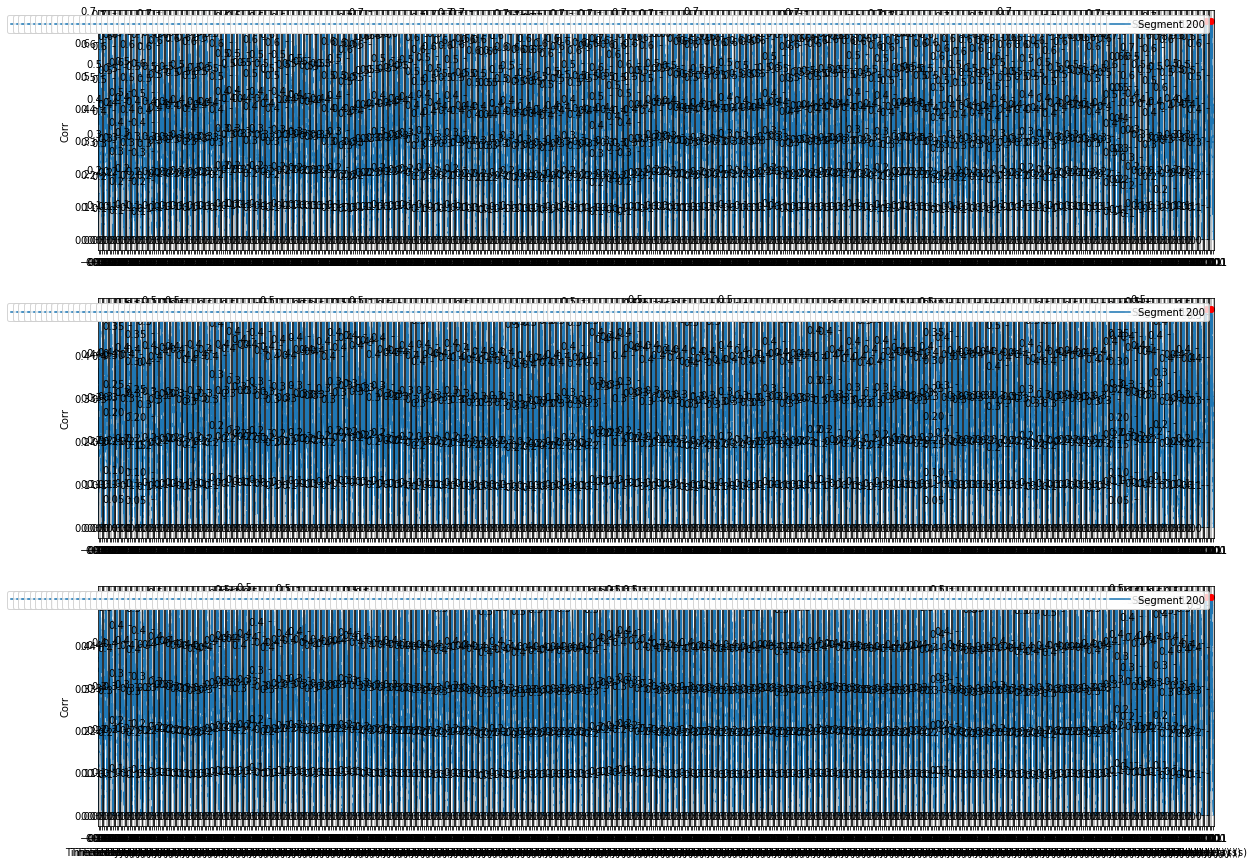

In [21]:
tdoa_correlations = correlate_segments(normalized_fragments_combined, num_segments, sps, c, distances, id_to_station)

In [22]:
tdoa_correlations

[(('CAR2', 'CAR0'),
  array([ 8.00e-07,  6.90e-06, -3.30e-06, -2.79e-05,  3.60e-06, -1.70e-06,
         -2.59e-05, -2.56e-05, -2.53e-05,  3.20e-06, -2.47e-05, -2.42e-05,
         -2.41e-05, -2.38e-05, -2.33e-05, -2.28e-05, -2.22e-05, -2.18e-05,
         -2.14e-05,  7.40e-06, -6.50e-06, -2.11e-05,  4.00e-06, -2.07e-05,
         -2.83e-05, -1.70e-06, -2.77e-05, -2.02e-05, -2.78e-05, -2.69e-05,
         -2.65e-05, -2.60e-05, -2.82e-05, -1.68e-05, -2.48e-05, -2.44e-05,
         -1.55e-05,  1.07e-05, -1.54e-05, -1.52e-05, -1.46e-05, -1.41e-05,
         -1.35e-05, -1.34e-05, -1.31e-05, -1.25e-05, -2.70e-05, -2.69e-05,
         -2.73e-05, -2.74e-05, -2.63e-05, -2.60e-05, -2.57e-05, -2.52e-05,
         -2.44e-05, -2.49e-05, -2.40e-05, -2.38e-05, -2.73e-05, -7.30e-06,
         -2.67e-05,  6.80e-06, -2.63e-05, -1.00e-06, -2.07e-05, -2.54e-05,
         -2.54e-05, -2.53e-05, -2.50e-05, -2.52e-05, -2.50e-05, -2.36e-05,
         -2.33e-05, -2.28e-05, -2.25e-05, -2.18e-05, -2.14e-05, -2.38e-05,
     

In [60]:
def plot_fragments_with_segments(fragments, sps, segment_boundaries):
    num_fragments = len(fragments)
    fig, axs = plt.subplots(num_fragments, figsize=(20, num_fragments * 2), sharex=True)

    # Zajistěte, že axs je vždy seznamem pro konzistentní indexaci, i když je jen jeden fragment
    if num_fragments == 1:
        axs = [axs]

    for i, (filename, fragment) in enumerate(fragments):
        # Vytvoření časové osy pro každý signál
        time_axis = np.linspace(0, len(fragment) / sps, num=len(fragment))

        # Vykreslení signálu
        if fragment.ndim == 2 and fragment.shape[1] > 1:  # Pokud máme vícekanálový signál
            for ch in range(fragment.shape[1]):
                axs[i].plot(time_axis, fragment[:, ch], label=f'Channel {ch}')
        else:  # Pro jednokanálový signál
            axs[i].plot(time_axis, fragment, label=f'Signal: {filename}')

        # Přidání svislých čar pro společné hranice segmentů
        for boundary in segment_boundaries:
            axs[i].axvline(x=boundary / sps, color='r', linestyle='--', linewidth=1)

        axs[i].set_title(f'Signal: {filename}')
        axs[i].set_ylabel('Amplitude')
        axs[i].legend(loc='upper right')

    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

In [61]:
def calculate_total_energy(signal):
    """Calculate the total energy of a signal."""
    return np.sum(np.square(signal))

def calculate_segments_boundaries(signal, num_segments):
    """
    Calculate segment boundaries for a signal based on the energy content.
    The signal is divided into segments so that each segment has a roughly equal amount of the total energy.
    """
    total_energy = calculate_total_energy(signal)
    energy_per_segment = total_energy / num_segments
    boundaries = []
    current_energy = 0
    start_index = 0

    for index, sample in enumerate(signal):
        current_energy += np.sum(np.square(sample))
        # Check if the current segment reached the energy threshold or it's the last sample
        if current_energy >= energy_per_segment or index == len(signal) - 1:
            boundaries.append(start_index)
            start_index = index + 1
            current_energy = 0

    return boundaries[1:]  # Return boundaries excluding the start of the signal

def segment_signal_by_boundaries(signal, boundaries):
    """
    Segment the signal using the predefined boundaries.
    """
    segments = []
    start = 0
    for end in boundaries + [None]:  # Add None to include the last segment to the end of the signal
        segments.append(signal[start:end])
        start = end
    return segments

# Nejprve najděte signál s nejmenší celkovou energií a určete hranice segmentů
energies = [calculate_total_energy(signal) for _, signal in normalized_fragments_selected]
min_energy_signal = normalized_fragments_selected[np.argmin(energies)][1]

# Calculate boundaries based on the signal with the smallest total energy
boundaries = calculate_segments_boundaries(min_energy_signal, num_segments)

# Use the calculated boundaries to segment all signals
segmented_signals = []
for name, signal in normalized_fragments_selected:
    segments = segment_signal_by_boundaries(signal, boundaries)
    segmented_signals.append((name, segments))


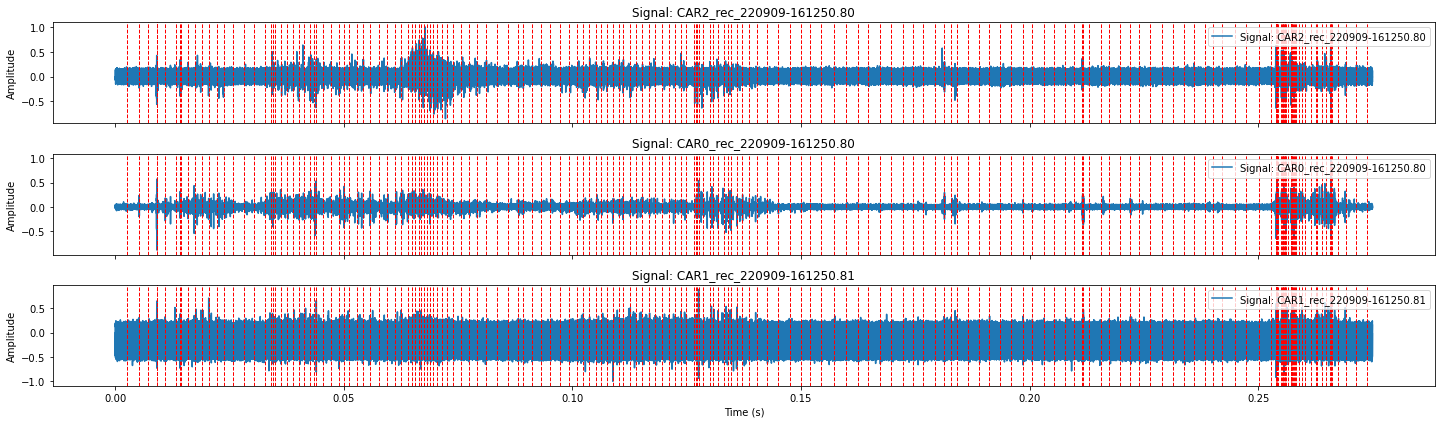

In [62]:
plot_fragments_with_segments(normalized_fragments_selected, sps, boundaries)

In [26]:
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt
from itertools import combinations

def correlate_adaptive_segments(signal_fragments, num_segments, sps, c, distances, id_to_station, threshold_ratio=0.5):
    """
    Correlate segments of signals with adaptive lengths to find TDOA
    """

    # Dynamically segment each signal based on the energy content
    energies = [calculate_total_energy(signal) for _, signal in signal_fragments]
    min_energy_signal = signal_fragments[np.argmin(energies)][1]

    # Calculate boundaries based on the signal with the smallest total energy
    boundaries = calculate_segments_boundaries(min_energy_signal, num_segments)

    # Use the boundaries calculated on the least energetic signal to segment all signals
    segmented_signals = []
    for name, signal in signal_fragments:  # assuming signal_fragments is the correct variable to iterate over
        segments = segment_signal_by_boundaries(signal, boundaries)
        segmented_signals.append((name, segments))

    # Setup figure layout
    num_pairs = len(segmented_signals) * (len(segmented_signals) - 1) // 2
    fig, axs = plt.subplots(nrows=num_pairs, ncols=num_segments, figsize=(20, 5 * num_pairs), squeeze=False)
    
    tdoa_results = {}
    combo_idx = 0

    for (name1, segments1), (name2, segments2) in combinations(segmented_signals, 2):
        station1 = id_to_station[name1]
        station2 = id_to_station[name2]
        station_pair = tuple(sorted([station1, station2]))

        max_delay_time = distances[station_pair] / c
        max_delay_samples = int(max_delay_time * sps)

        tdoa_list = np.empty(num_segments)
        tdoa_list.fill(np.nan)

        for seg_idx in range(num_segments):
            segment1 = segments1[seg_idx % len(segments1)]
            segment2 = segments2[seg_idx % len(segments2)]
            corr = correlate(segment1, segment2, mode='full', method='auto')
            corr /= np.sqrt(np.dot(segment1, segment1) * np.dot(segment2, segment2))
            lags = np.arange(-len(segment1) + 1, len(segment2))

            max_corr_index = np.argmax(corr)
            max_corr_value = corr[max_corr_index]
            if abs(lags[max_corr_index]) <= max_delay_samples:
                max_lag = lags[max_corr_index]
                tdoa_list[seg_idx] = max_lag / sps
            
            ax = axs[combo_idx, seg_idx]
            ax.plot(lags / sps, corr)
            if not np.isnan(tdoa_list[seg_idx]):
                ax.plot(tdoa_list[seg_idx], max_corr_value, 'ro')
            ax.set_title(f'{station1} vs. {station2}: Seg {seg_idx+1}')
            ax.set_facecolor('lightgrey' if np.isnan(tdoa_list[seg_idx]) else 'white')
            ax.grid(True)

            # Only set the labels for the outer plots
            if combo_idx < num_pairs - 1:
                ax.set_xticklabels([])
            if seg_idx > 0:
                ax.set_yticklabels([])

        tdoa_results[(station1, station2)] = np.array(tdoa_list)
        combo_idx += 1

    plt.tight_layout()
    plt.show()

    return [(station_pair, tdoas) for station_pair, tdoas in tdoa_results.items()]


/tmp/ipykernel_727/3555566855.py:72: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


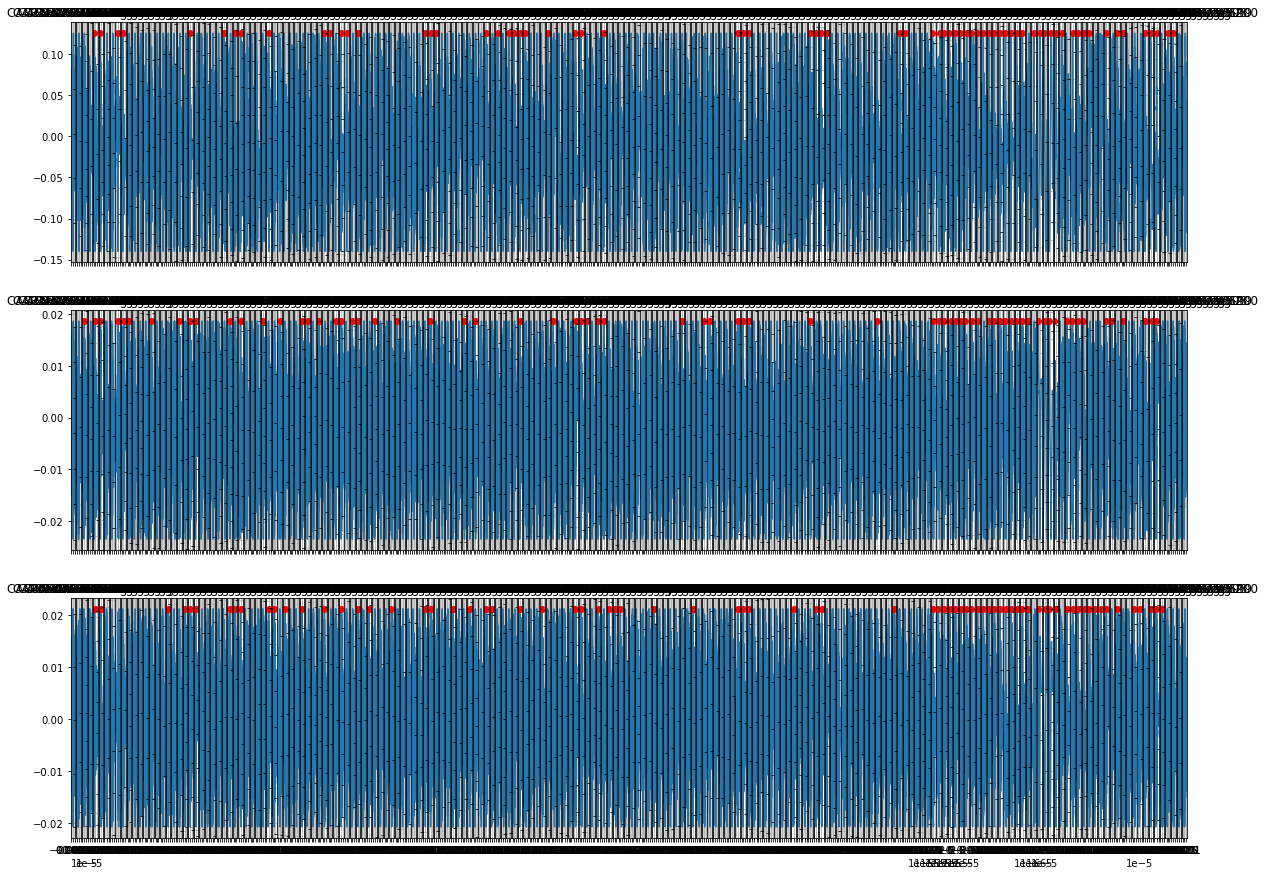

In [27]:
tdoa_correlations = correlate_adaptive_segments(normalized_fragments_selected, num_segments, sps, c, distances, id_to_station)

In [28]:
tdoa_correlations

[(('CAR2', 'CAR0'),
  array([      nan,       nan,       nan,       nan, -2.67e-05, -1.00e-05,
               nan,       nan, -2.65e-05, -2.54e-05,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan, -3.06e-05,       nan,       nan,
               nan,       nan,       nan, -3.11e-05,       nan, -3.14e-05,
         -2.09e-05,       nan,       nan,       nan,       nan, -1.94e-05,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan, -3.17e-05, -3.20e-05,       nan,
         -3.23e-05, -3.25e-05,       nan, -3.16e-05,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan, -2.74e-05, -2.71e-05,  1.90e-05,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan, -3.17e-05,       nan, -2.89e-05,       nan,
     

In [95]:
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt
from itertools import combinations

def correlate_adaptive_segments(signal_fragments, num_segments, sps, c, distances, id_to_station, threshold_ratio=0.5):
    energies = [calculate_total_energy(signal) for _, signal in signal_fragments]
    min_energy_signal = signal_fragments[np.argmin(energies)][1]
    boundaries = calculate_segments_boundaries(min_energy_signal, num_segments)
    segmented_signals = []
    for name, signal in signal_fragments:
        segments = segment_signal_by_boundaries(signal, boundaries)
        segmented_signals.append((name, segments))

    num_pairs = len(segmented_signals) * (len(segmented_signals) - 1) // 2
    fig, axs = plt.subplots(nrows=num_pairs, ncols=num_segments, figsize=(20, 5 * num_pairs), squeeze=False)
    
    tdoa_results = {}
    combo_idx = 0

    for (name1, segments1), (name2, segments2) in combinations(segmented_signals, 2):
        station1 = id_to_station[name1]
        station2 = id_to_station[name2]
        station_pair = tuple(sorted([station1, station2]))
        
        max_delay_samples = int((distances[station_pair] / c) * sps)
        tdoa_list = []

        corr_results = []  # Store correlation results for determining Y axis range
        lags_list = []  # Store lag values for each correlation

        # Calculate correlations for all segments in the pair
        for segment1, segment2 in zip(segments1, segments2):
            corr = correlate(segment1, segment2, mode='full', method='auto')
            corr /= np.sqrt(np.dot(segment1, segment1) * np.dot(segment2, segment2))
            corr_results.append(corr)
            lags = np.arange(-len(segment1) + 1, len(segment2))
            lags_list.append(lags)

        # Determine Y axis range from all correlations in the current row
        all_corrs = np.concatenate(corr_results)
        global_min_corr, global_max_corr = all_corrs.min(), all_corrs.max()

        # Plot the correlations with a unified Y axis range
        for seg_idx, (corr, lags) in enumerate(zip(corr_results, lags_list)):
            ax = axs[combo_idx, seg_idx]
            max_corr_index = np.argmax(np.abs(corr))
            max_lag = lags[max_corr_index]

            ax.plot(lags / sps, corr)
            ax.set_xlim([min(lags) / sps, max(lags) / sps])
            ax.set_ylim(global_min_corr, global_max_corr)

            # Check if the maximum correlation lag is within the acceptable delay range
            if abs(max_lag) <= max_delay_samples:
                tdoa = max_lag / sps
                tdoa_list.append(tdoa)
                ax.set_facecolor('white')
            else:
                ax.set_facecolor('lightgrey')
                tdoa_list.append(np.nan)

            ax.grid(True)

            # Add titles to the top row and labels to the left column
            if combo_idx == 0:
                ax.set_title(f'Seg {seg_idx + 1}')
            if seg_idx == 0:
                ax.set_ylabel(f'{station1} vs. {station2}')

            # Clean up axis labels for non-edge plots
            if combo_idx < num_pairs - 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Time lag (s)')
            if seg_idx > 0:
                ax.set_yticklabels([])

        tdoa_results[station_pair] = np.array(tdoa_list)
        combo_idx += 1

    plt.tight_layout()
    plt.show()

    return [(station_pair, tdoas) for station_pair, tdoas in tdoa_results.items()]


/tmp/ipykernel_727/1225977410.py:82: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


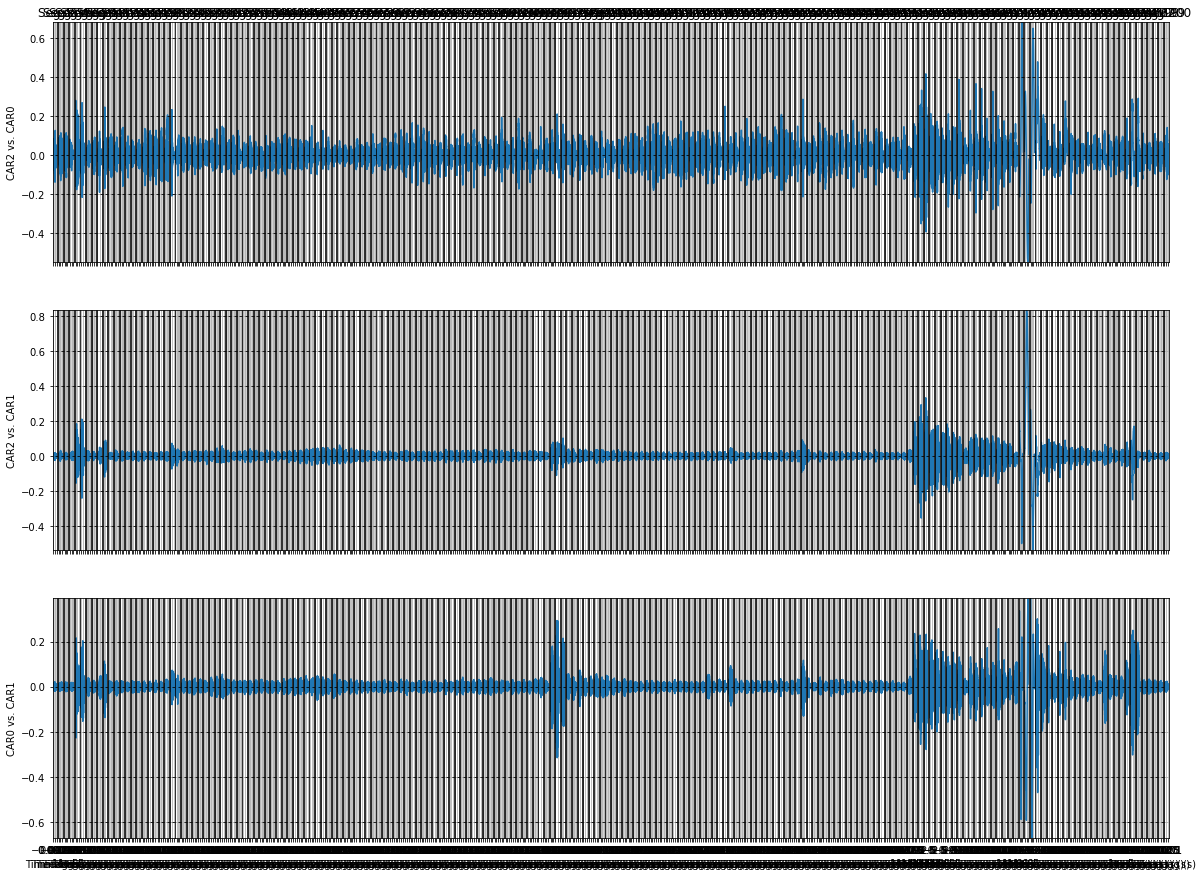

In [67]:
tdoa_correlations = correlate_adaptive_segments(normalized_fragments_selected, num_segments, sps, c, distances, id_to_station)

In [68]:
tdoa_correlations

[(('CAR0', 'CAR2'),
  array([      nan,       nan,       nan, -2.81e-05, -2.67e-05, -1.00e-05,
               nan,       nan, -2.55e-05, -2.54e-05,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan, -3.06e-05,  3.00e-06,       nan,
               nan,       nan,       nan, -3.11e-05,       nan, -3.14e-05,
         -2.09e-05,       nan,       nan,       nan,       nan, -1.94e-05,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan, -3.17e-05, -3.20e-05, -3.24e-05,
         -3.23e-05, -3.25e-05, -3.29e-05, -3.16e-05,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan, -2.71e-05,       nan,
               nan,       nan,       nan, -1.32e-05, -2.00e-07, -3.01e-05,
         -6.60e-06,       nan,       nan,       nan, -2.89e-05,       nan,
     

In [123]:
def estimate_positions_for_segments(stations_ecef, tdoa_correlations, id_to_station):
    successful_estimates = []  # List to store successful estimates for each segment
    
    # Assuming each entry in tdoa_correlations has the same number of segments
    num_segments = len(tdoa_correlations[0][1])
    
    # Iterate through each segment
    for segment_idx in range(num_segments):
        segment_tdoas = []
        
        # Collect TDOA for the current segment from each station pair
        for station_pair, tdoas in tdoa_correlations:
            segment_tdoas.append(tdoas[segment_idx])
        
        # Convert station identifiers to ECEF coordinates
        sensors = np.array([stations_ecef[station] for station in id_to_station.values()])
        
        # Check if we have at least two non-NaN TDOA values
        valid_tdoa_count = np.count_nonzero(~np.isnan(segment_tdoas))
        if valid_tdoa_count < 2:
            print(f"Segment {segment_idx+1} does not have enough valid TDOA, skipping...")
            continue
        
        # No need to filter out NaN values from TDOAs
        # Pass all TDOAs including NaN values to estimate_strike_position
        estimated_position = estimate_strike_position(sensors, np.array(segment_tdoas))
        if estimated_position is not None:
            successful_estimates.append((estimated_position, segment_tdoas))
            
    return successful_estimates


# Example usage:
# Assuming 'stations_ecef', 'tdoa_correlations', and 'id_to_station' are defined,
# and you have an 'estimate_strike_position' function ready for use.
# Replace the dummy append with a call to your position estimation function.
successful_positions = estimate_positions_for_segments(stations_ecef, tdoa_correlations, id_to_station)
successful_positions


Segment 1 does not have enough valid TDOA, skipping...
Segment 2 does not have enough valid TDOA, skipping...
Segment 3 does not have enough valid TDOA, skipping...
Segment 4 does not have enough valid TDOA, skipping...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 356.43000065605105
            Iterations: 21
            Function evaluations: 63
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.16333378727700826
            Iterations: 25
            Function evaluations: 76
            Gradient evaluations: 25
Segment 7 does not have enough valid TDOA, skipping...
Segment 8 does not have enough valid TDOA, skipping...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.974620465078349
            Iterations: 19
            Function evaluations: 68
            Gradient evaluations: 19
Optimization terminated successfully    

[(array([3958058.73922198,  960174.86604567, 4894800.93399501]),
  [-2.67e-05, -1.25e-05, -1.85e-05]),
 (array([3956923.72031702,  959096.10058811, 4895934.98704397]),
  [-1e-05, -1.16e-05, -9e-07]),
 (array([3965134.71303913,  946497.05452427, 4891469.31408148]),
  [-2.55e-05, 2.1e-06, nan]),
 (array([3959808.64509839,  962167.75019438, 4892992.10711232]),
  [-2.54e-05, -4.24e-05, -1.66e-05]),
 (array([3954565.71280566,  961679.84745041, 4897406.95347234]),
  [3e-06, nan, -1.38e-05]),
 (array([3958774.40048962,  962366.26120802, 4893808.99323286]),
  [-2.09e-05, -3.87e-05, -1.79e-05]),
 (array([3959240.13673162,  959820.14561267, 4893891.26713134]),
  [nan, -2.73e-05, -6.6e-06]),
 (array([3961343.96537806,  955610.71829892, 4892926.86325234]),
  [-3.17e-05, nan, 3.3e-06]),
 (array([3958394.17818591,  957206.13945567, 4895068.136355  ]),
  [-3.24e-05, 7.5e-06, -1.05e-05]),
 (array([3958936.29465454,  957758.12743401, 4894519.74961374]),
  [-3.23e-05, -1.1e-06, -1.15e-05]),
 (array([395

In [124]:
from pyproj import Transformer
import folium

# Inicializace transformátoru pro převod z ECEF do WGS84
transformer = Transformer.from_crs("epsg:4978", "epsg:4326", always_xy=True)

# Vytvoření prázdné mapy
m = folium.Map(location=[0, 0], zoom_start=9)  # Upravte pro vhodné počáteční umístění a přiblížení

# Iterace přes všechny úspěšné odhady pozic a příslušné TDOA hodnoty
for position_with_tdoa in successful_positions:
    if position_with_tdoa is not None:
        position, tdoa_values = position_with_tdoa
        # Převod ECEF souřadnic na geodetické souřadnice (lat, lon)
        lon, lat, alt = transformer.transform(*position[:2], position[2])
        
        # Vytvoření pop-up textu zahrnujícího TDOA hodnoty
        popup_text = f"Estimated position from\nTDOA: {tdoa_values}"
    
        # Přidání markeru pro každou odhadovanou pozici s menší značkou a pop-up informacemi
        folium.CircleMarker(
            [lat, lon],
            radius=5,  # Menší velikost značky
            popup=popup_text,
            color='red',
            fill=True,
            fill_color='red'
        ).add_to(m)
    else:
        # Tady můžete zacházet s případy, kdy position_with_tdoa je None
        print("Invalid position estimate, skipped.")

# Převod a přidání každé stanice jako marker na mapu
for station_name, ecef_coords in stations_ecef.items():
    latlon = transformer.transform(ecef_coords[0], ecef_coords[1], ecef_coords[2])
    folium.Marker([latlon[1], latlon[0]], popup=station_name).add_to(m)

# Výpočet středu a poloměru limitujícího kruhu v ECEF
center_ecef, radius, _ = circumcircle_center_and_radius(station_positions)


# Převod středu kružnice na geodetické souřadnice
center_lon, center_lat, alt = transformer.transform(*center_ecef[:2], center_ecef[2])

print(center_lon, center_lat, alt)
print(transformer.transform(3954597.28634092,961610.55345991,4897393.60142656))

# Přidání kruhu constrains na mapu
folium.Circle(
    location=[center_lat, center_lon],
    radius=radius,  # Poloměr je již v metrech
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.2,
).add_to(m)

folium.CircleMarker(
    [center_lat, center_lon],
    radius=5,  # Menší velikost značky
    popup=popup_text,
    color='yellow',
    fill=True,
    fill_color='yellow'
).add_to(m)

# Nastavení centra mapy na první odhadovanou pozici (pouze pro lepší vizualizaci)
if successful_positions:
    first_position, _ = successful_positions[0]
    first_lat, first_lon, alt = transformer.transform(*first_position[:2], first_position[2])
    m.location = [first_lon, first_lat]

# Zobrazení mapy
m

#[3951810.45564357  959691.17279736 4897866.04067359]


13.666950053944763 50.46172896589687 2269.259697410278
(13.666950053944733, 50.46172896589691, 2269.2596974112093)


In [125]:
from pyproj import Transformer
import folium
from shapely.geometry import MultiPoint
from shapely.ops import unary_union

transformer = Transformer.from_crs("epsg:4978", "epsg:4326", always_xy=True)

# Vytvoření prázdné mapy
m = folium.Map(location=[0, 0], zoom_start=10)  # Upravte pro vhodné počáteční umístění a přiblížení

# Shromažďování geografických souřadnic pro všechny validní odhady
coords = []
for position_with_tdoa in successful_positions:
    if position_with_tdoa is not None:
        position, _ = position_with_tdoa
        lat, lon, _ = transformer.transform(*position[:2], position[2])
        coords.append((lon, lat))

# Vytvoření MultiPoint objektu ze shromážděných souřadnic
if coords:
    multi_point = MultiPoint(coords)
    # Vytvoření konvexní obálky (nebo unary_union pro více komplexní obal)
    convex_hull = multi_point.convex_hull

    # Převod konvexní obálky na seznam souřadnic pro folium Polygon
    hull_coords = list(convex_hull.exterior.coords)
    folium.Polygon(hull_coords, color='blue', fill=True, fill_opacity=0.5).add_to(m)

# Převod a přidání každé stanice jako marker na mapu
for station_name, ecef_coords in stations_ecef.items():
    latlon = transformer.transform(ecef_coords[0], ecef_coords[1], ecef_coords[2])
    folium.Marker([latlon[1], latlon[0]], popup=station_name).add_to(m)

# Nastavení centra mapy na první odhadovanou pozici (pouze pro lepší vizualizaci)
if successful_positions:
    first_position, _ = successful_positions[0]
    first_lat, first_lon, _ = transformer.transform(*first_position[:2], first_position[2])
    m.location = [first_lon, first_lat]
    
# Zobrazení mapy
m


In [126]:
import folium
from pyproj import Transformer
import numpy as np

# Inicializace transformátoru pro převod ECEF na WGS84
transformer = Transformer.from_crs("epsg:4978", "epsg:4326", always_xy=True)

# Vytvoření mapy
m = folium.Map(location=[0, 0], zoom_start=10)

# Nastavení centra mapy na první odhadovanou pozici (pouze pro lepší vizualizaci)
if successful_positions:
    first_position, _ = successful_positions[0]
    first_lat, first_lon, _ = transformer.transform(*first_position[:2], first_position[2])
    m.location = [first_lon, first_lat]

# Převod a přidání každé stanice jako marker na mapu
for station_name, ecef_coords in stations_ecef.items():
    latlon = transformer.transform(ecef_coords[0], ecef_coords[1], ecef_coords[2])
    folium.Marker([latlon[1], latlon[0]], popup=station_name).add_to(m)

    
# Předpokládáme, že successful_positions obsahuje seznam ECEF pozic
trajectory_coords = []
for position_with_tdoa in successful_positions:
    if position_with_tdoa is not None:
        position, _ = position_with_tdoa
        lon, lat, _ = transformer.transform(*position[:2], position[2])
        trajectory_coords.append((lat, lon))

connected_points = [trajectory_coords[0]]  # Začneme s prvním bodem jako spojeným
for point in trajectory_coords[1:]:
    # Převod bodů na numpy pole pro snadný výpočet vzdálenosti
    existing_points = np.array(connected_points)
    new_point = np.array(point)
    
    # Výpočet vzdáleností mezi novým bodem a již spojenými body
    strike_point_distances = np.sqrt(np.sum((existing_points - new_point) ** 2, axis=1))
    
    # Najít nejbližší spojený bod
    nearest_index = np.argmin(strike_point_distances)
    nearest_point = connected_points[nearest_index]
    
    # Vytvořit spojnici mezi novým bodem a nejbližším spojeným bodem
    folium.PolyLine(locations=[point, nearest_point], color="blue", weight=2.5, opacity=0.8).add_to(m)
    
    # Přidat nový bod do seznamu spojených bodů
    connected_points.append(point)

# Přidání markerů pro každý bod
#for idx, (lat, lon) in enumerate(trajectory_coords):
#    folium.CircleMarker(
#        [lat, lon],
#        radius=5,
#        popup=f"Point {idx+1}",
#        color='red',
#        fill=True,
#        fill_color='red'
#    ).add_to(m)

# Zobrazit mapu
m


# Test of numerical approach

Calculate position of randomly generated lightning TDOAs data


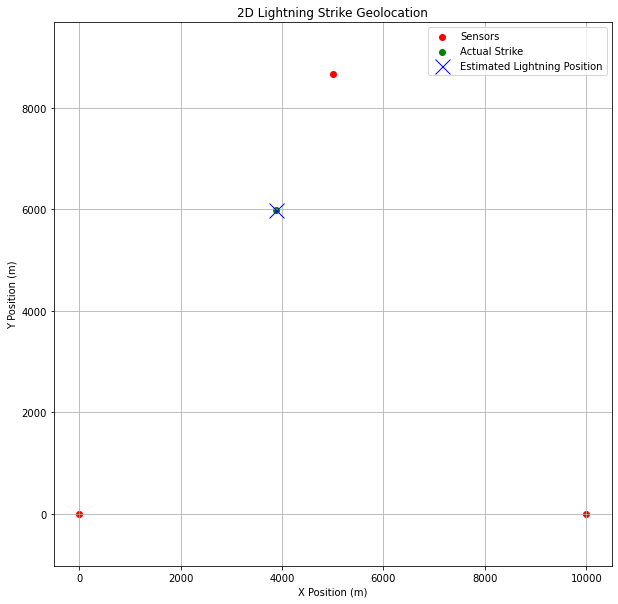

Actual Strike Position: [3885.79801971 5995.35078729]
Estimated Strike Position: [3885.79802618 5995.35077621]


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Constants
c = 3e8  # Speed of light in m/s

# Helper functions
def generate_random_strike(area_size=(10000, 10000)):
    """Generate a random lightning strike location within the given area."""
    return np.random.rand(2) * area_size

def calculate_distances(strike_position, sensors):
    """Calculate the distance from the strike position to each sensor."""
    return np.linalg.norm(sensors - strike_position, axis=1)

def calculate_tdoa(distances):
    """Calculate TDOA values. The third TDOA is theoretically not independent, but in practice there is noise"""
    # return (distances - distances[1]) / c
    return np.array([distances[2] - distances[0], 
                     distances[2] - distances[1], 
                     distances[0] - distances[1]]) / c

def estimate_strike_position(sensors, tdoas):
    """
    Estimate the lightning strike position using the TDOA measurements.
    """
    # Optimization function to minimize
    def func_to_minimize(strike):
        estimated_distances = calculate_distances(strike, sensors)
        estimated_tdoas = calculate_tdoa(estimated_distances)
        # Minimize the difference between the actual TDOA and the estimated TDOA
        return np.sum((estimated_tdoas - tdoas )**2)

    # Initial guess (we use the geometry center of the sensor positions)
    initial_guess = np.mean(sensors, axis=0)
    
    # Minimize the optimization function
    result = minimize(func_to_minimize, initial_guess, method='Nelder-Mead')
    
    # Return the estimated position of the lightning strike
    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed")

# Place three sensors
sensors = np.array([[0, 0], [10000, 0], [5000, 8660]])  # Equilateral triangle layout

# Generate a random lightning strike
strike_position = generate_random_strike()

# Calculate actual distances and TDOAs
distances = calculate_distances(strike_position, sensors)
tdoas = calculate_tdoa(distances)

# Estimate the lightning strike position
estimated_strike = estimate_strike_position(sensors, tdoas)

# Plotting
plt.figure(figsize=(10, 10))
plt.scatter(sensors[:, 0], sensors[:, 1], c='red', label='Sensors')
plt.scatter(strike_position[0], strike_position[1], c='green', label='Actual Strike')
plt.plot(*estimated_strike, 'bx', label='Estimated Lightning Position', markersize=15)
plt.legend()
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.title('2D Lightning Strike Geolocation')
plt.grid(True)
plt.axis('equal')
plt.show()

# Print actual and estimated positions
print("Actual Strike Position:", strike_position)
print("Estimated Strike Position:", estimated_strike)


# Automatické získání pozice auta

Pokusy s automatickou extrakcí pozice aut ze záznamu

In [37]:
# Tohle by mělo extrahovat souřadnice z GPS záznamů blízko  zvolenému časovému úseku, ale nefunguje to. 
from datetime import datetime, timedelta

def find_closest_coordinates(log_file_path, time_window_start, time_window_end):
    tw_start = datetime.strptime(time_window_start, "%H:%M:%S.%f").time()
    tw_end = datetime.strptime(time_window_end, "%H:%M:%S.%f").time()

    closest_time = None
    closest_coords = None
    closest_time_diff = timedelta.max

    with open(log_file_path, 'r', errors='ignore') as file:
        for line in file:
            try:
                if line.startswith('$GNGGA') or line.startswith('$GPGGA'):
                    msg = pynmea2.parse(line)
                    msg_time = msg.timestamp  # předpokládáme, že je to objekt datetime.time bez informací o časové zóně
                    if msg_time:
                        if tw_start <= msg_time <= tw_end:
                            current_datetime = datetime.combine(datetime.min, msg_time)
                            start_datetime = datetime.combine(datetime.min, tw_start)
                            end_datetime = datetime.combine(datetime.min, tw_end)
                            time_diff_start = abs(current_datetime - start_datetime)
                            time_diff_end = abs(current_datetime - end_datetime)
                            min_time_diff = min(time_diff_start, time_diff_end)

                            if min_time_diff < closest_time_diff:
                                closest_time = msg_time
                                closest_coords = (msg.latitude, msg.longitude)
                                closest_time_diff = min_time_diff
            except pynmea2.ParseError:
                # Ignorování chyb při parsování
                continue

    if closest_time:
        return closest_time, closest_coords, closest_time_diff.total_seconds()
    else:
        return None, None, None



In [38]:
log_file_path = '/storage/experiments/2022/0909_bourka_CAR2/gps/base_gps_CAR2_20220909_105954.log'

time_window_start = "16:12:50.45"  # Začátek extrakce
time_window_end = "16:12:50.85"    # Konec extrakce

closest_time, closest_coords, time_diff = find_closest_coordinates(log_file_path, time_window_start, time_window_end)

if closest_time:
    print(f"Nearest coordinates to time window: {closest_coords} at {closest_time.strftime('%H:%M:%S.%f')}, time difference: {time_diff}")
else:
    print("No coordinates found within the time window.")



NameError: name 'pynmea2' is not defined

# Algebraic approach Quadratic Planar (QP) method
Attemt to implement the [Quadratic Planar (QP) method](https://journals.ametsoc.org/view/journals/atot/17/3/1520-0426_2000_017_0279_drafvt_2_0_co_2.xml) but the algorithm has not fixet Z height, therefore is undetermined in case of only three stations. 

Also the measurement TDOAs needs to be corrected firts for epsilon noise to get relevant solution. E.g A-B + B-C = A-C. 



In [ ]:
def accurate_qp_method(sensor_positions, tdoa, c=3e8):
    """
    Accurate estimation of the lightning position using the QP method.
    This function uses a more precise approach than the simplified version.
    """
    # The sensor positions are assumed to be in a planar coordinate system with the first sensor at the origin.
    # The reference sensor for TDOA is the first sensor.
    x2, y2 = sensor_positions[1]
    x3, y3 = sensor_positions[2]
    
    # Compute q' values based on the equation q' = (1/2) * (r_i^2 - c^2 * t_i^2) for i = 2, 3
    q2_prime = 0.5 * (x2**2 + y2**2 - c**2 * tdoa[1]**2)
    q3_prime = 0.5 * (x3**2 + y3**2 - c**2 * tdoa[2]**2)
    
    # Calculate the coefficients A, B, and C for the quadratic equation in r
    A = c**2 * (tdoa[2]**2 - tdoa[1]**2) - (x3 - x2)**2 - (y3 - y2)**2
    B = 2 * ((x3 - x2) * q2_prime - (x2 - x3) * q3_prime)
    C = q2_prime**2 - q3_prime**2
    
    # Solve the quadratic equation to find r
    discriminant = B**2 - 4*A*C
    if discriminant < 0:
        return None  # Complex roots, no solution
    
    r1 = (-B + np.sqrt(discriminant)) / (2*A)
    r2 = (-B - np.sqrt(discriminant)) / (2*A)
    
    # Choose the positive root which has the smallest absolute value as the solution
    r = min([r for r in [r1, r2] if r >= 0], key=abs, default=None)
    if r is None:
        return None  # No valid r found
    
    # With r calculated, we can solve the linear system to find the estimated position (x, y)
    # The linear system is given by: q = Qr where Q is the matrix composed of the sensor positions (excluding the first one),
    # and q is the vector of q' values for the corresponding sensors.
    Q = np.array([[x2, y2], [x3, y3]])
    q = np.array([q2_prime, q3_prime])
    
    # Solving the linear system Qr = q for r (position vector [x, y])
    position_vector = np.linalg.solve(Q, q)
    
    # Add the position of the first sensor to get absolute position
    estimated_position = sensor_positions[0] + position_vector
    
    return estimated_position

# Perform the TDOA calculation and estimation again
tdoa = calculate_tdoa(lightning_position, sensor_positions)
estimated_position = accurate_qp_method(sensor_positions, tdoa)

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(*sensor_positions.T, 'ro', label='Sensors')
plt.plot(*lightning_position, 'g*', label='Actual Lightning Position', markersize=15)
if estimated_position is not None:
    plt.plot(*estimated_position, 'bx', label='Estimated Lightning Position', markersize=15)
plt.legend()
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Lightning Position Estimation with Accurate QP Method')
plt.grid(True)
plt.show()

# Let's also return the positions for reference
(lightning_position, estimated_position)


In [ ]:
# Redefine the accurate_qp_method_debug function to include 'c' within the scope for plotting
def accurate_qp_method_debug(sensor_positions, tdoa):
    """
    Accurate estimation of the lightning position using the QP method.
    This function uses a more precise approach than the simplified version.
    Added debug information to identify issues with the estimation.
    """
    c = 3e8  # Speed of light in m/s
    x2, y2 = sensor_positions[1]
    x3, y3 = sensor_positions[2]
    t2, t3 = tdoa[1], tdoa[2]
    
    q2_prime = 0.5 * (x2**2 + y2**2 - c**2 * t2**2)
    q3_prime = 0.5 * (x3**2 + y3**2 - c**2 * t3**2)
    
    A = c**2 * (t3**2 - 2*t2*t3 + t2**2) - ((x3 - x2)**2 + (y3 - y2)**2)
    B = 2 * ((x3 - x2) * q2_prime - (x2 - x3) * q3_prime)
    C = q2_prime**2 - q3_prime**2
    
    discriminant = B**2 - 4*A*C
    print(f"Discriminant: {discriminant}, A: {A}, B: {B}, C: {C}")

    if discriminant < 0:
        print("No real solution. Complex roots encountered.")
        return None  # Complex roots, no solution
    
    r1 = (-B + np.sqrt(discriminant)) / (2*A)
    r2 = (-B - np.sqrt(discriminant)) / (2*A)
    
    r = min([r for r in [r1, r2] if r >= 0], key=abs, default=None)
    if r is None:
        print("No valid r found.")
        return None
    
    Q = np.array([[x2, y2], [x3, y3]])
    q = np.array([q2_prime, q3_prime])
    
    position_vector = np.linalg.solve(Q, q)
    estimated_position = sensor_positions[0] + position_vector
    
    return estimated_position

# Perform the TDOA calculation and estimation again with debug information
estimated_position = accurate_qp_method_debug(sensor_positions, tdoa)

# Plotting TDOA circles and fixing the previous scope error
plt.figure(figsize=(10, 8))
c = 3e8  # Speed of light in m/s, for plotting purposes
for i, sensor in enumerate(sensor_positions):
    circle = plt.Circle(sensor, tdoa[i]*c, color='blue', fill=False, linestyle='dotted')
    plt.gca().add_artist(circle)
plt.plot(*sensor_positions.T, 'ro', label='Sensors')
plt.plot(*lightning_position, 'g*', label='Actual Lightning Position', markersize=15)
if estimated_position is not None:
    plt.plot(*estimated_position, 'bx', label='Estimated Lightning Position', markersize=15)
plt.legend()
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('TDOA Circles and Lightning Position Estimation with Debugging')
plt.grid(True)
plt.axis('equal')
plt.show()

# Print out the estimated position or None
estimated_position



In [ ]:
def revised_qp_method(sensor_positions, tdoa, c=3e8):
    """
    Revised version of the QP method.
    Corrects the calculation of the coefficients and discriminant.
    """
    # Define positions relative to the first sensor
    rel_positions = sensor_positions - sensor_positions[0]
    x2, y2 = rel_positions[1]
    x3, y3 = rel_positions[2]
    
    # Calculate q' values based on the relative positions and TDOA
    q2_prime = 0.5 * (x2**2 + y2**2 - c**2 * tdoa[1]**2)
    q3_prime = 0.5 * (x3**2 + y3**2 - c**2 * tdoa[2]**2)
    
    # Coefficients for the quadratic equation
    A = (x3 - x2)**2 + (y3 - y2)**2 - c**2 * (tdoa[2] - tdoa[1])**2
    B = 2 * ((x3 - x2) * q2_prime - (x2 - x3) * q3_prime)
    C = q2_prime**2 - q3_prime**2
    
    # Discriminant
    discriminant = B**2 - 4*A*C
    # Return detailed information if discriminant is negative
    if discriminant < 0:
        return None, {
            "A": A,
            "B": B,
            "C": C,
            "discriminant": discriminant,
            "message": "Complex roots, no real solution"
        }
    
    # Roots
    sqrt_discriminant = np.sqrt(discriminant)
    r1 = (-B + sqrt_discriminant) / (2*A)
    r2 = (-B - sqrt_discriminant) / (2*A)
    
    # Choose the smallest non-negative root as the correct solution
    r = min(filter(lambda r: r >= 0, [r1, r2]), default=None)
    # Return None if no non-negative root is found
    if r is None:
        return None, {
            "A": A,
            "B": B,
            "C": C,
            "discriminant": discriminant,
            "roots": (r1, r2),
            "message": "No valid non-negative root found"
        }
    
    # Since we know r, we can solve the linear system for (x, y)
    # The equations are: x2*x + y2*y = q2_prime and x3*x + y3*y = q3_prime
    Q = np.array([[x2, y2], [x3, y3]])
    q = np.array([q2_prime, q3_prime])
    
    # Solve the linear system to find the estimated position
    estimated_position = np.linalg.solve(Q, q)
    
    return estimated_position, {
        "A": A,
        "B": B,
        "C": C,
        "discriminant": discriminant,
        "roots": (r1, r2),
        "chosen_root": r,
        "estimated_position": estimated_position
    }

# Rerun the estimation with the revised method
estimated_position, debug_info = revised_qp_method(sensor_positions, tdoa)

# Plotting for visualization
plt.figure(figsize=(10, 8))
plt.plot(*sensor_positions.T, 'ro', label='Sensors')
plt.plot(*lightning_position, 'g*', label='Actual Lightning Position', markersize=15)
if estimated_position is not None:
    plt.plot(*estimated_position, 'bx', label='Estimated Lightning Position', markersize=15)
plt.legend()
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Lightning Position Estimation with Revised QP Method')
plt.grid(True)
plt.show()

# Return the estimated position and debug info
(estimated_position, debug_info)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_lightning_location(area_size=(1000, 1000)):
    """Generate a random lightning strike location."""
    x = np.random.uniform(0, area_size[0])
    y = np.random.uniform(0, area_size[1])
    return np.array([x, y])

def calculate_tdoa(lightning_position, sensor_positions, c=3e8):
    """Calculate Time-Difference-of-Arrival for each sensor."""
    distances = np.linalg.norm(sensor_positions - lightning_position, axis=1)
    times = distances / c
    tdoa = times - times[0]  # Reference to the first sensor
    return tdoa

def generate_hyperbola(sensor1, sensor2, tdoa, c=3e8):
    """
    Generate points on a hyperbola corresponding to the TDOA between two sensors.
    """
    # Calculate the foci distance of the hyperbola (2a)
    d = np.linalg.norm(sensor1 - sensor2)
    
    # Calculate the difference in distances from the foci to any point on the hyperbola (2c)
    # c > a for a hyperbola, here c is the TDOA times the speed of light
    diff_distance = c * tdoa  # This is 2c in the hyperbola equation
    
    # Calculate semi-minor axis (b) using hyperbola equation c^2 = a^2 + b^2
    a = d / 2
    b = np.sqrt((diff_distance / 2)**2 - a**2)
    
    # Generate points on the hyperbola
    theta = np.linspace(-np.pi/2, np.pi/2, 1000)
    x = a * np.cosh(theta)
    y = b * np.sinh(theta)
    
    # Rotation matrix to align the hyperbola with the sensors
    delta_x = sensor2[0] - sensor1[0]
    delta_y = sensor2[1] - sensor1[1]
    angle = np.arctan2(delta_y, delta_x)
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])
    
    # Rotate and translate hyperbola points
    points = np.dot(rotation_matrix, np.vstack([x, y]))
    points[0, :] += (sensor1[0] + sensor2[0]) / 2
    points[1, :] += (sensor1[1] + sensor2[1]) / 2
    
    return points

def accurate_qp_method(sensor_positions, tdoa, c=3e8):
    """
    Accurate estimation of the lightning position using the QP method.
    """
    x2, y2 = sensor_positions[1]
    x3, y3 = sensor_positions[2]
    t2, t3 = tdoa[1], tdoa[2]
    
    q2_prime = 0.5 * (x2**2 + y2**2 - c**2 * t2**2)
    q3_prime = 0.5 * (x3**2 + y3**2 - c**2 * t3**2)
    
    A = c**2 * (t3**2 - 2*t2*t3 + t2**2) - ((x3 - x2)**2 + (y3 - y2)**2)
    B = 2 * ((x3 - x2) * q2_prime - (x2 - x3) * q3_prime)
    C = q2_prime**2 - q3_prime**2
    
    discriminant = B**2 - 4*A*C
    if discriminant < 0:
        return None  # Complex roots, no solution
    
    r1 = (-B + np.sqrt(discriminant)) / (2*A)
    r2 = (-B - np.sqrt(discriminant)) / (2*A)
    
    r = min([r for r in [r1, r2] if r >= 0], key=abs, default=None)
    if r is None:
        return None
    
    Q = np.array([[x2, y2], [x3, y3]])
    q = np.array([q2_prime, q3_prime])
    
    position_vector = np.linalg.solve(Q, q)
    estimated_position = sensor_positions[0] + position_vector
    
    return estimated_position

def plot_tdoa_and_estimation(sensor_positions, lightning_position, estimated_position, tdoa, c=3e8):
    """Plot the TDOA circles and estimated lightning position."""
    plt.figure(figsize=(10, 8))
    for i, sensor in enumerate(sensor_positions):
        circle = plt.Circle(sensor, tdoa[i]*c, color='blue', fill=False, linestyle='dotted')
        plt.gca().add_artist(circle)
    plt.plot(*sensor_positions.T, 'ro', label='Sensors')
    plt.plot(*lightning_position, 'g*', label='Actual Lightning Position', markersize=15)
    if estimated_position is not None:
        plt.plot(*estimated_position, 'bx', label='Estimated Lightning Position', markersize=15)
    plt.legend()
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title('TDOA Circles and Lightning Position Estimation')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Define sensor positions (example)
sensor_positions = np.array([[0, 0], [1000, 0], [500, 1000]])

# Generate a random lightning strike location
lightning_position = generate_lightning_location()

# Calculate TDOA based on the lightning strike location
tdoa = calculate_tdoa(lightning_position, sensor_positions)

# Estimate the lightning position using the QP method
estimated_position = accurate_qp_method(sensor_positions, tdoa)

# Plotting
plt.figure(figsize=(10, 8))

# Plot hyperbolas for each pair of sensors
for i in range(len(sensor_positions)):
    for j in range(i+1, len(sensor_positions)):
        points = generate_hyperbola(sensor_positions[i], sensor_positions[j], tdoa[j] - tdoa[i])
        plt.plot(points[0, :], points[1, :], 'b--')

plt.plot(*sensor_positions.T, 'ro', label='Sensors')
plt.plot(*lightning_position, 'g*', label='Actual Lightning Position', markersize=15)
if estimated_position is not None:
    plt.plot


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_strike(area_size=(1000, 1000)):
    """Generate a random lightning strike location."""
    x = np.random.uniform(0, area_size[0])
    y = np.random.uniform(0, area_size[1])
    return np.array([x, y])

def calculate_tdoa(strike_position, sensors, c=3e8):
    """Calculate Time-Difference-of-Arrival for each sensor."""
    distances = np.linalg.norm(sensors - strike_position, axis=1)
    tdoas = distances / c
    return tdoas - tdoas[0]  # Relative to the first sensor

def estimate_strike_position(sensors, tdoas, c=3e8):
    """Estimate lightning strike position using hyperbolic trilateration."""
    # For hyperbolic trilateration, use pairs of sensors to define hyperbolas
    # Here we simplify to use only the first three sensors
    s1, s2, s3 = sensors[:3]
    t1, t2, t3 = tdoas[:3]

    # Calculate hyperbola parameters for each pair
    # Hyperbola between sensor 1 and sensor 2
    a12 = c * (t2 - t1) / 2
    f12 = np.linalg.norm(s1 - s2) / 2
    center12 = (s1 + s2) / 2
    b12 = np.sqrt(a12**2 - f12**2) if a12**2 > f12**2 else 0

    # Hyperbola between sensor 1 and sensor 3
    a13 = c * (t3 - t1) / 2
    f13 = np.linalg.norm(s1 - s3) / 2
    center13 = (s1 + s3) / 2
    b13 = np.sqrt(a13**2 - f13**2) if a13**2 > f13**2 else 0

    # Assuming hyperbolas intersect at the correct strike location, we can solve for the intersection
    # This is a simplified example and does not handle cases where hyperbolas do not intersect due to measurement errors
    # For real scenarios, more sophisticated methods like least squares can be used to find the best estimate

    # Plot hyperbolas for visualization
    plt.figure(figsize=(10, 8))
    t = np.linspace(-np.pi, np.pi, 300)
    # For each hyperbola, plot the two branches
    for center, a, b in [(center12, a12, b12), (center13, a13, b13)]:
        if b > 0:  # Valid hyperbola
            plt.plot(center[0] + a * np.cosh(t), center[1] + b * np.sinh(t), 'b-', lw=0.5)
            plt.plot(center[0] + a * np.cosh(t), center[1] - b * np.sinh(t), 'b-', lw=0.5)

    # Plot sensor positions
    for sensor in sensors:
        plt.plot(*sensor, 'ro')

    # This is where the real intersection calculation would take place.
    # For now, we just return the first sensor position for demonstration.
    # A real implementation would require solving the equations for the intersection of hyperbolas.

    return s1

# Sensor positions (example)
sensors = np.array([[0, 0], [1000, 0], [500, 500]])

# Generate a random lightning strike location
strike_position = generate_random_strike()

# Calculate TDOA based on the lightning strike location
tdoas = calculate_tdoa(strike_position, sensors)

# Estimate the lightning position using hyperbolic trilateration
estimated_position = estimate_strike_position(sensors, tdoas)

# Show the plot
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Hyperbolic Trilateration of Lightning Strike')
plt.grid(True)
plt.axis('equal')
plt.show()

# Return estimated position
estimated_position
